In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 1
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng * ind
        outs.append(out_is)
        res = np.average(outs)
    return res

def plot_loss(train_loss, test_loss, i, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    train_losses = []
    train_recalls = []
    train_recall_outputs = [] 

    test_losses = []
    test_recalls = []
    test_recall_outputs = []

    new_outputs = []
    
    train_correct = 0
    test_correct = 0
    
    for i, ele in enumerate(tqdm.tqdm(train_ds)):
        if i == 0:
            continue
        model.train()
        optim.zero_grad() #reset gradients after update
        x, y = convert(ele[0], ele[1]) #sample x,y from S_train
        out = update(x, y) #get S_train output/score
        log_out = torch.log(out) #take log
        # Calculate train recall
        train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
        if train_score > 0.6:
            train_correct += 1 #contribute to train recall
        train_recall_outputs.append(train_score) #store the train scores
        
        optim.zero_grad() #reset gradients for the second branch
        y_pmf = get_y_pmf(ele[2][1])
        x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
        out_prime = update(x_prime, y_prime) #get score'
        out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
        const = ele[3] #indicator
        (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
        optim.step() #gradient update

        model.eval()
        x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
        test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
        test_recall_outputs.append(test_score) #store the test scores
        if test_score > 0.6:
            test_correct += 1 #contribute to test recall
            
        #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
        for x, y in S_new[10*i:10*(i+1)]:
            x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
            new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
            new_outputs.append(new_score) #store the new unknown scores

        if i % 500 == 0:
            train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
            test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            train_recall = 100*train_correct/i #training recall
            train_recalls.append(train_recall) 
            test_recall = 100*test_correct/i #test recall
            test_recalls.append(test_recall)
            if i > 1000:
                train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
            else:
                train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
            train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
            test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


        if i % 5000 == 0:
            plot_recall(train_recalls, test_recalls, i, lamb, gamma)
            plot_loss(train_losses, test_losses, i, lamb, gamma)
            plot_cdf(train_cdf, test_cdf, i, lamb, gamma)
            print("New score: ", np.average(new_outputs[-20:]))
            print("Train score: ", np.average(train_score[-20:]))
            print("Test score: ", np.average(test_score[-20:]))

## Hyperparameter tuning

In [10]:
gammas = [1e-3]
lambdas = [1e28]

  1%|          | 4993/473047 [02:40<1:35:32, 81.65it/s] 

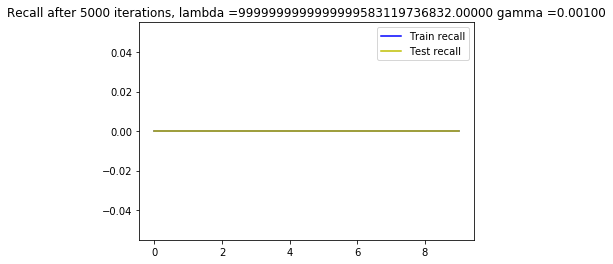

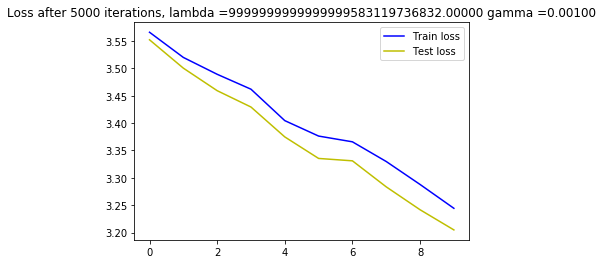

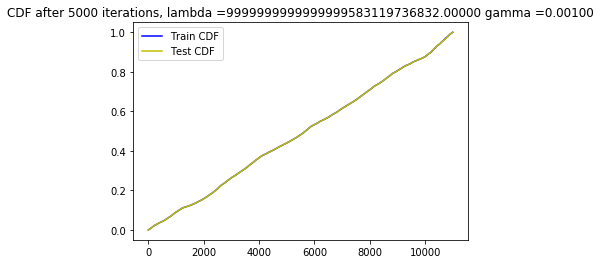

  1%|          | 5011/473047 [02:52<35:54:56,  3.62it/s]

New score:  0.062032193
Train score:  0.089905284
Test score:  0.08404954


  2%|▏         | 9996/473047 [05:32<1:35:24, 80.88it/s] 

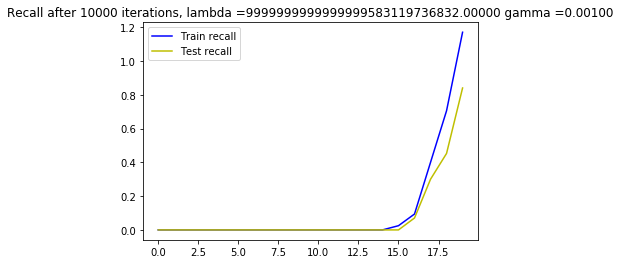

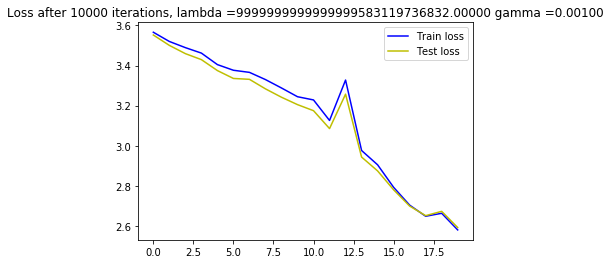

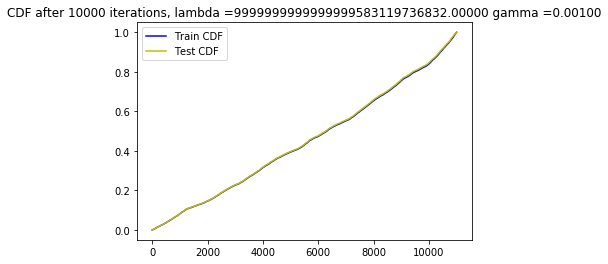

  2%|▏         | 10014/473047 [05:44<36:24:41,  3.53it/s]

New score:  0.17121631
Train score:  0.3474642
Test score:  0.30109864


  3%|▎         | 14995/473047 [08:27<1:33:55, 81.28it/s]  

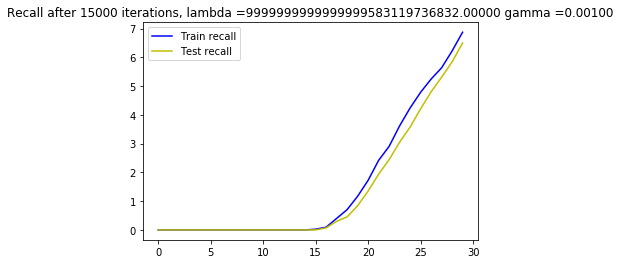

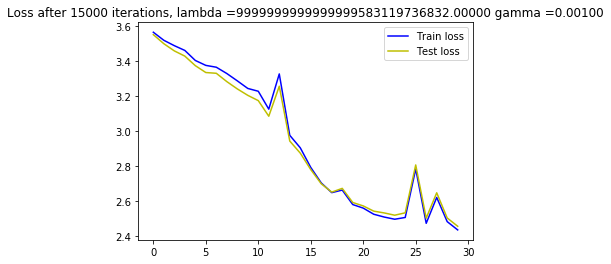

  3%|▎         | 14995/473047 [08:40<1:33:55, 81.28it/s]

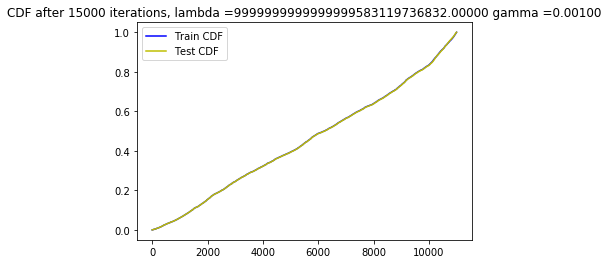

  3%|▎         | 15009/473047 [08:40<58:06:17,  2.19it/s]

New score:  0.19874865
Train score:  0.48352227
Test score:  0.24556439


  4%|▍         | 19996/473047 [11:23<1:36:33, 78.19it/s] 

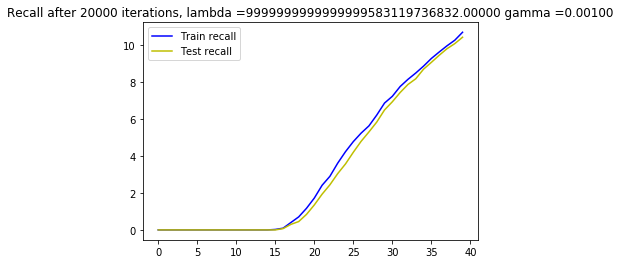

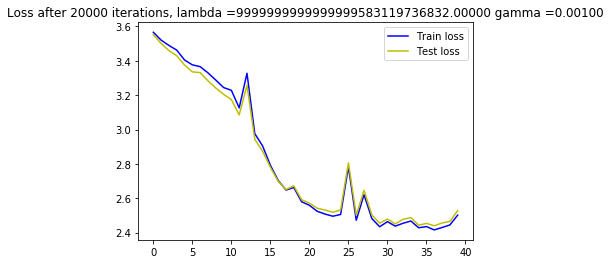

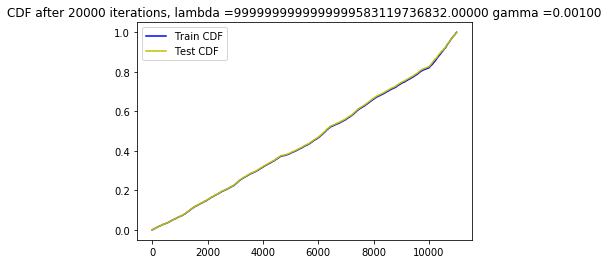

  4%|▍         | 20012/473047 [11:35<40:56:00,  3.07it/s]

New score:  0.04883262
Train score:  0.37386143
Test score:  0.3657061


  5%|▌         | 24995/473047 [14:23<1:41:58, 73.23it/s] 

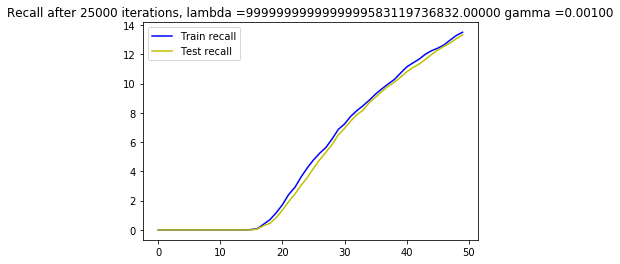

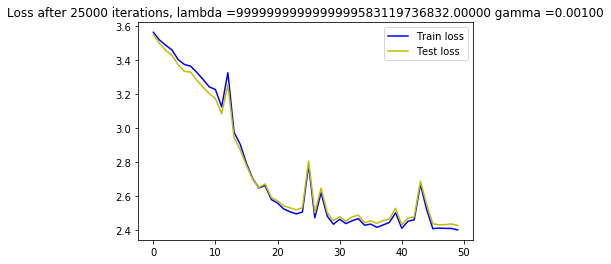

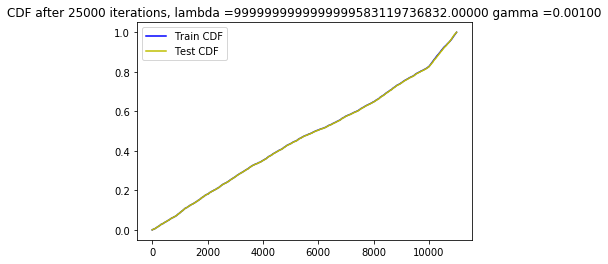

  5%|▌         | 25011/473047 [14:35<41:32:36,  3.00it/s]

New score:  0.1481555
Train score:  0.48192817
Test score:  0.32805657


  6%|▋         | 29995/473047 [17:40<1:38:36, 74.88it/s]  

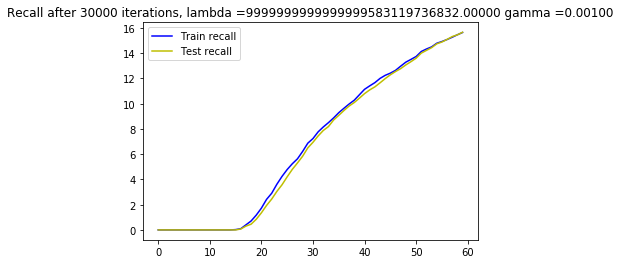

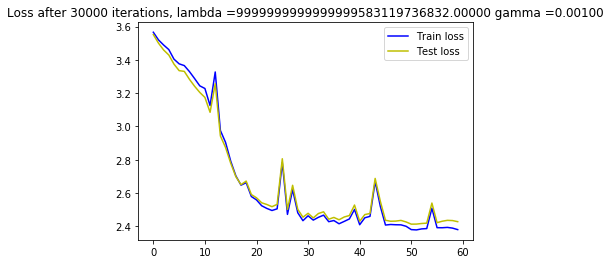

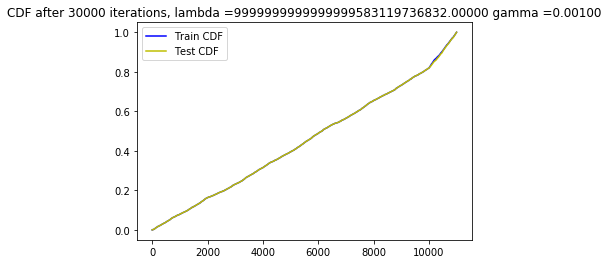

  6%|▋         | 30009/473047 [17:42<54:12:05,  2.27it/s]

New score:  0.15824744
Train score:  0.42295194
Test score:  0.4710413


  7%|▋         | 34999/473047 [20:35<1:37:09, 75.14it/s]  

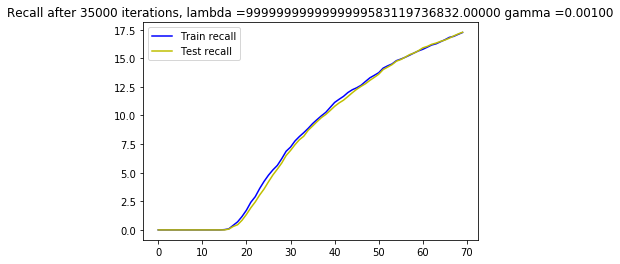

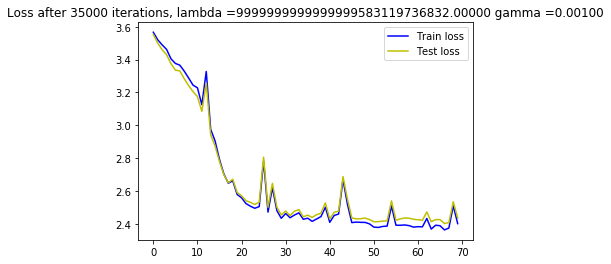

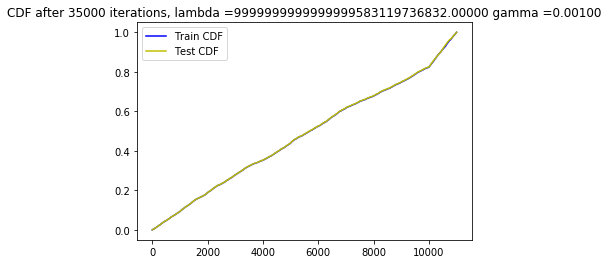

  7%|▋         | 35015/473047 [20:48<40:33:47,  3.00it/s]

New score:  0.06921309
Train score:  0.46433797
Test score:  0.35627398


  8%|▊         | 39996/473047 [23:50<1:37:37, 73.93it/s] 

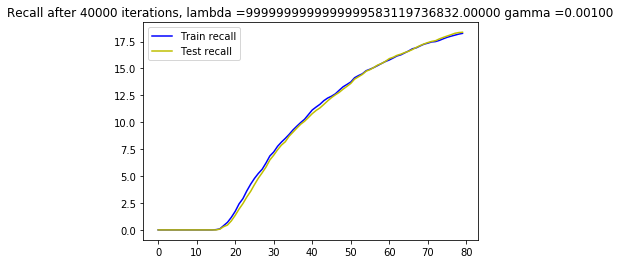

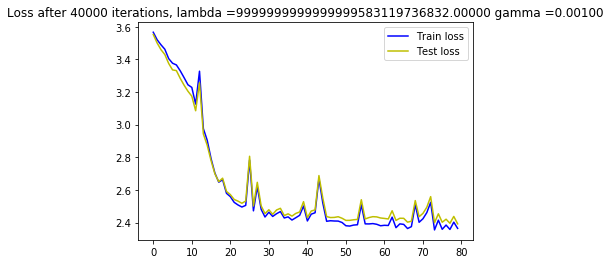

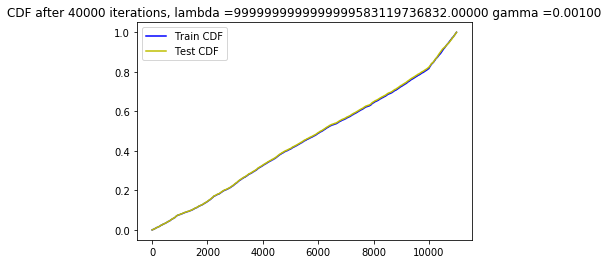

  8%|▊         | 40009/473047 [23:51<62:17:39,  1.93it/s]

New score:  0.15346627
Train score:  0.37807125
Test score:  0.44462767


 10%|▉         | 44993/473047 [26:42<1:36:33, 73.88it/s] 

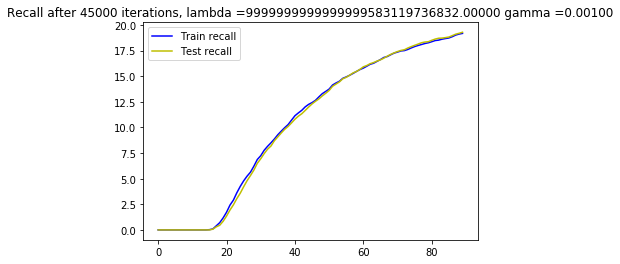

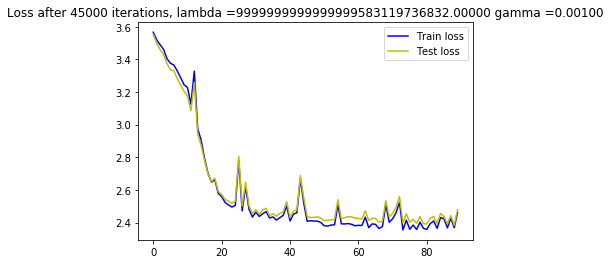

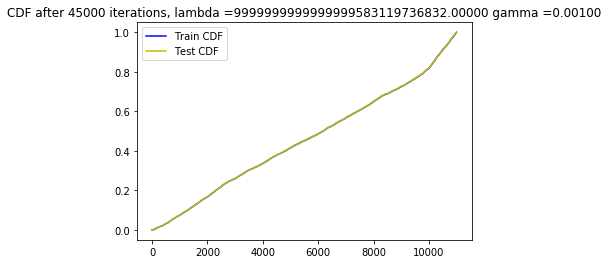

 10%|▉         | 45009/473047 [26:54<39:10:10,  3.04it/s]

New score:  0.18559922
Train score:  0.39549378
Test score:  0.28685758


 11%|█         | 49993/473047 [29:46<1:35:13, 74.05it/s] 

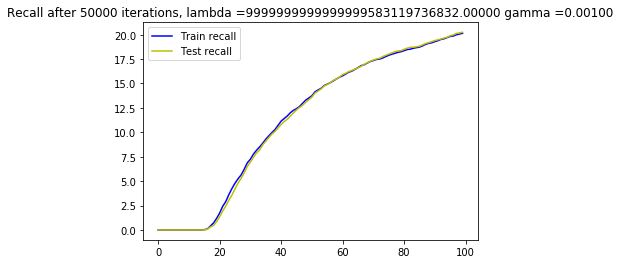

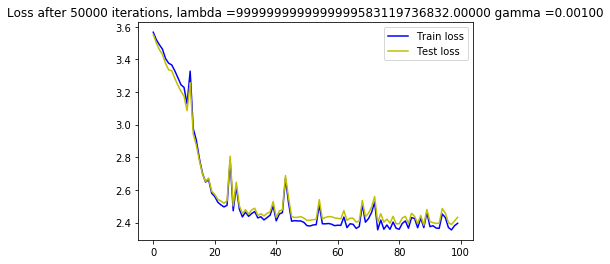

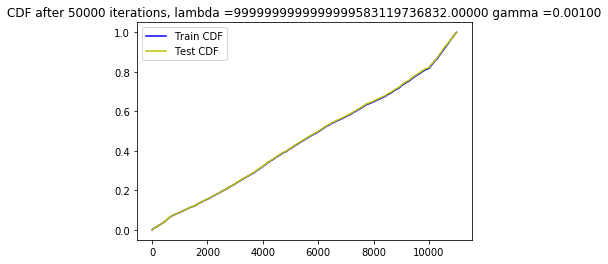

 11%|█         | 50009/473047 [29:58<38:31:56,  3.05it/s]

New score:  0.06880091
Train score:  0.32179293
Test score:  0.3902357


 12%|█▏        | 54998/473047 [32:51<1:35:13, 73.17it/s]  

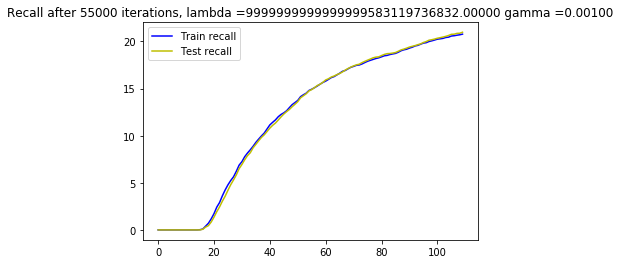

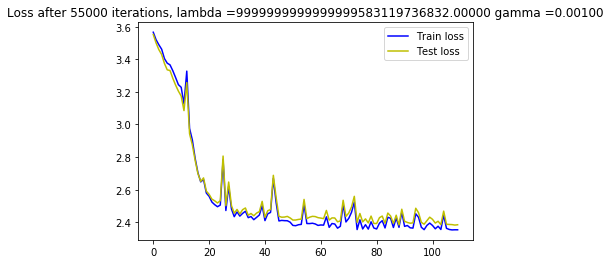

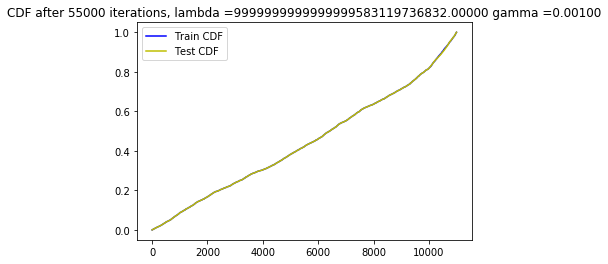

 12%|█▏        | 55014/473047 [33:03<38:49:59,  2.99it/s]

New score:  0.19692156
Train score:  0.46483904
Test score:  0.5286395


 13%|█▎        | 59997/473047 [35:57<1:31:11, 75.48it/s]  

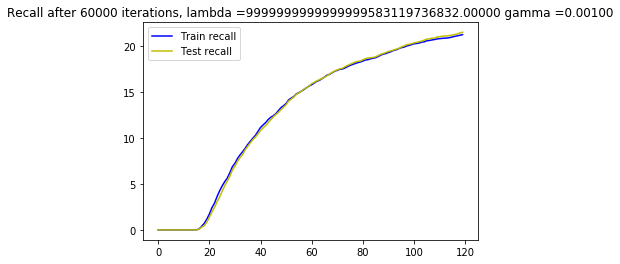

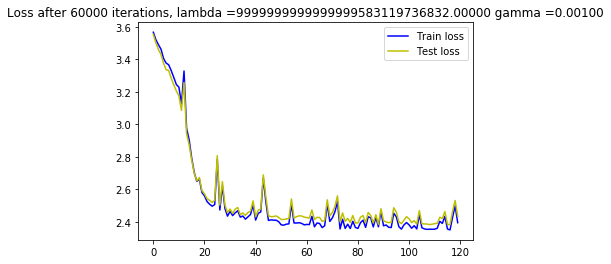

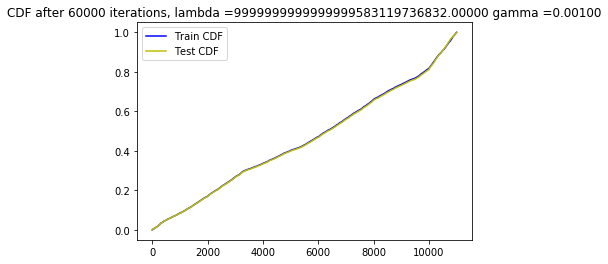

 13%|█▎        | 60013/473047 [36:09<38:04:22,  3.01it/s]

New score:  0.25796902
Train score:  0.39432603
Test score:  0.45234504


 14%|█▎        | 64994/473047 [39:02<1:31:37, 74.22it/s]  

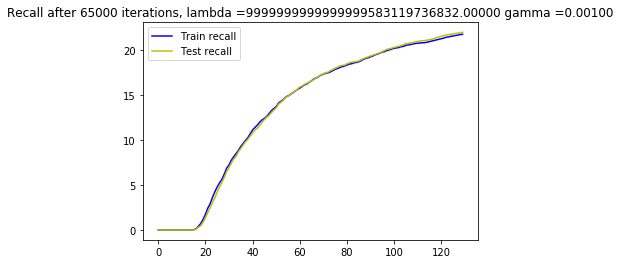

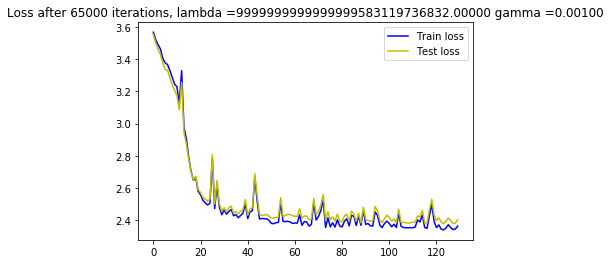

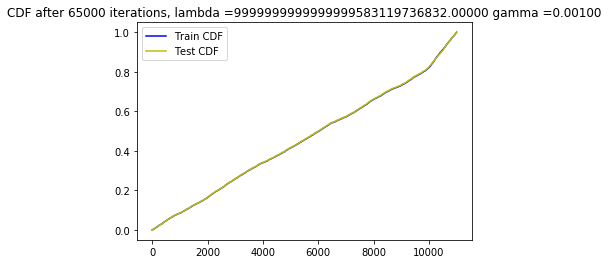

 14%|█▎        | 65010/473047 [39:15<38:02:44,  2.98it/s]

New score:  0.18864438
Train score:  0.40892658
Test score:  0.39373177


 15%|█▍        | 69997/473047 [42:20<1:29:41, 74.90it/s]  

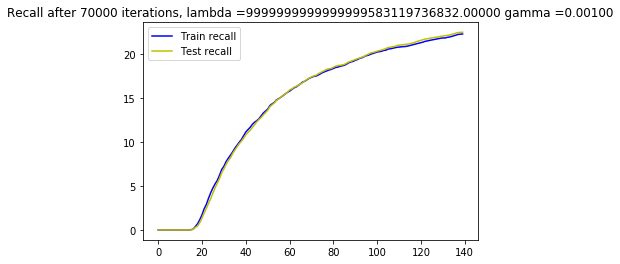

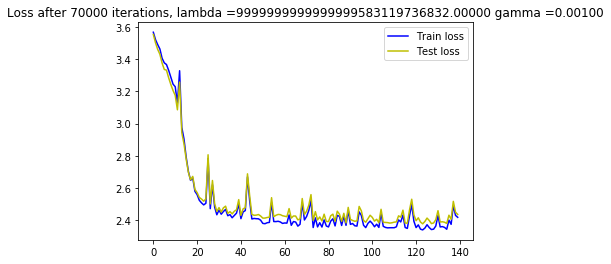

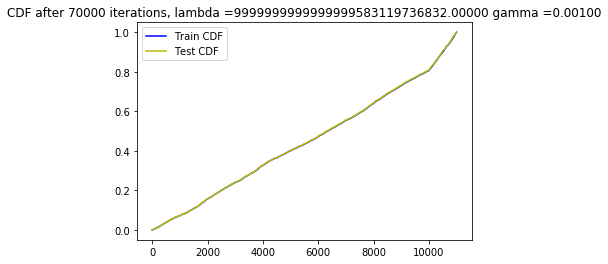

 15%|█▍        | 70009/473047 [42:21<73:44:47,  1.52it/s] 

New score:  0.13019994
Train score:  0.30995703
Test score:  0.29146656


 16%|█▌        | 74997/473047 [45:15<1:29:55, 73.78it/s] 

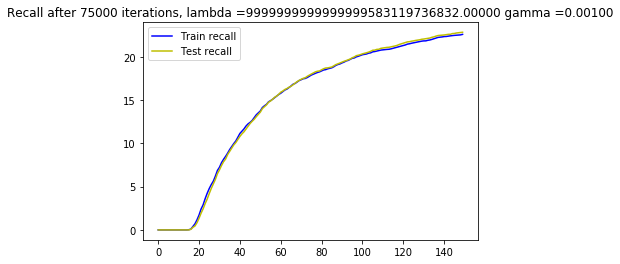

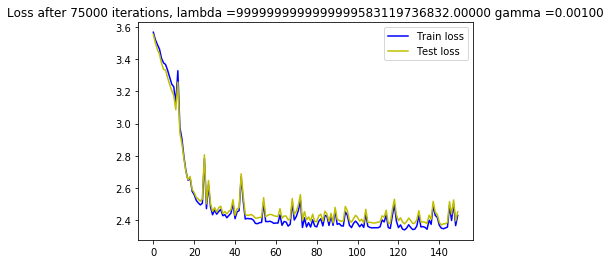

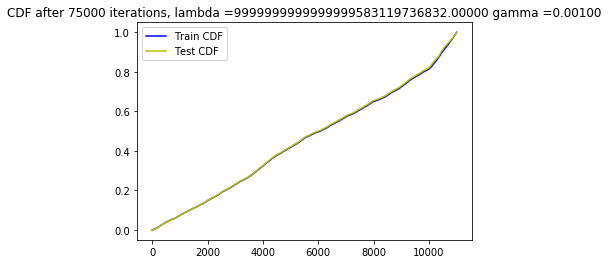

 16%|█▌        | 75013/473047 [45:27<36:56:55,  2.99it/s]

New score:  0.10051409
Train score:  0.5029328
Test score:  0.37857032


 17%|█▋        | 79996/473047 [48:16<1:19:12, 82.71it/s] 

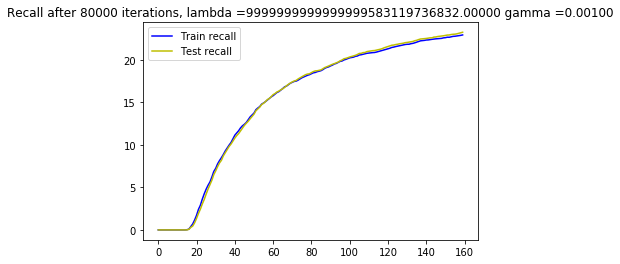

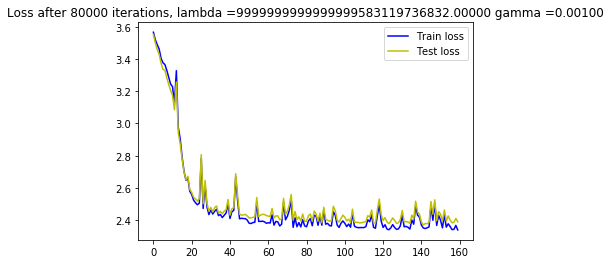

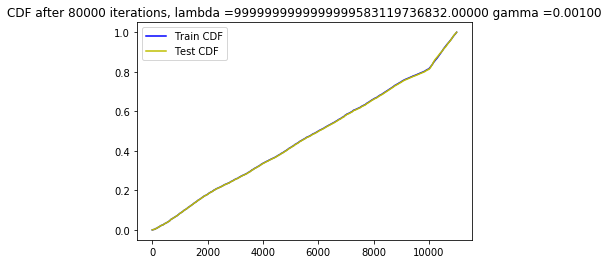

 17%|█▋        | 80014/473047 [48:28<32:39:00,  3.34it/s]

New score:  0.15699513
Train score:  0.42952672
Test score:  0.30885947


 18%|█▊        | 84998/473047 [51:14<1:20:05, 80.75it/s] 

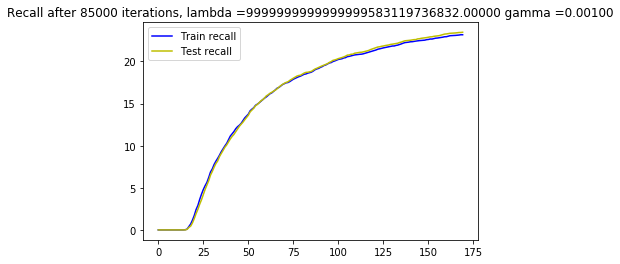

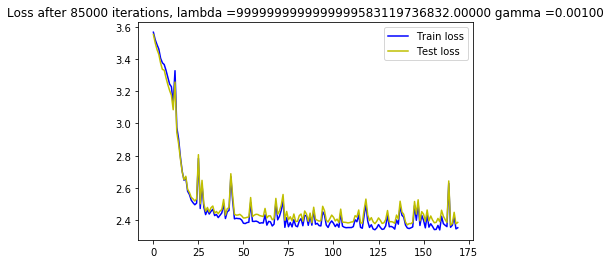

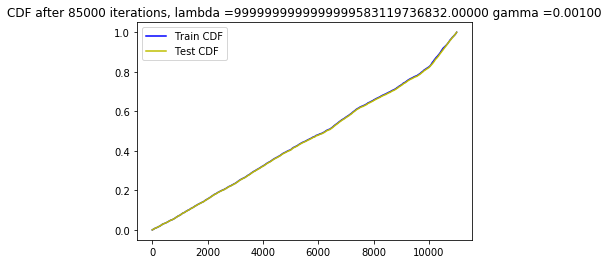

 18%|█▊        | 85016/473047 [51:27<31:55:38,  3.38it/s]

New score:  0.1858109
Train score:  0.5349523
Test score:  0.4397893


 19%|█▉        | 89994/473047 [54:13<1:16:41, 83.25it/s]  

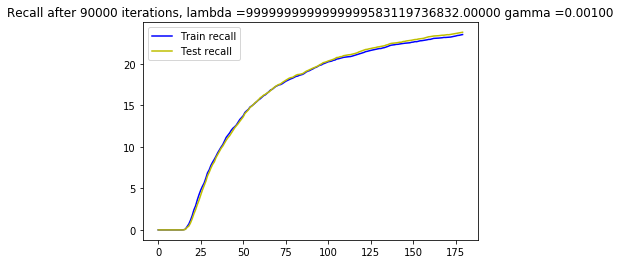

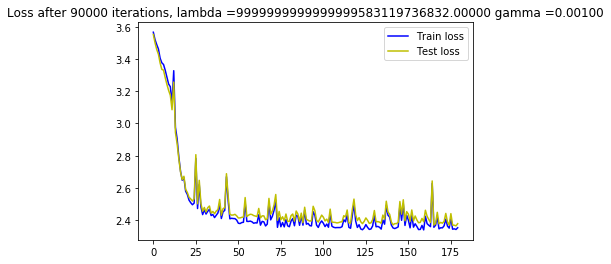

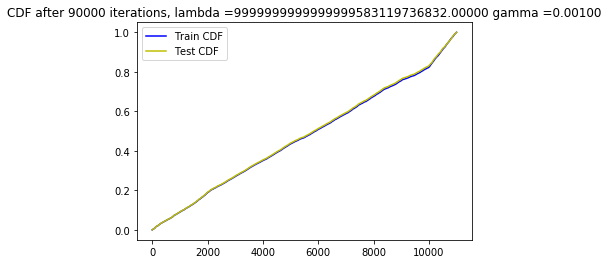

 19%|█▉        | 90012/473047 [54:25<31:23:49,  3.39it/s]

New score:  0.2082021
Train score:  0.36400074
Test score:  0.2795196


 20%|██        | 94999/473047 [57:11<1:14:24, 84.68it/s] 

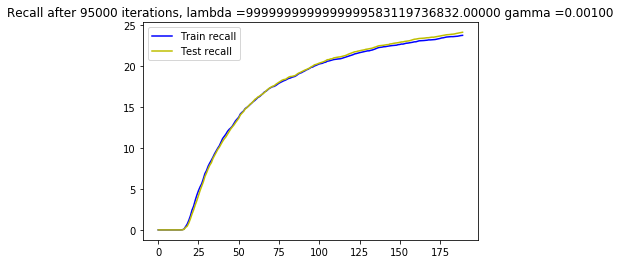

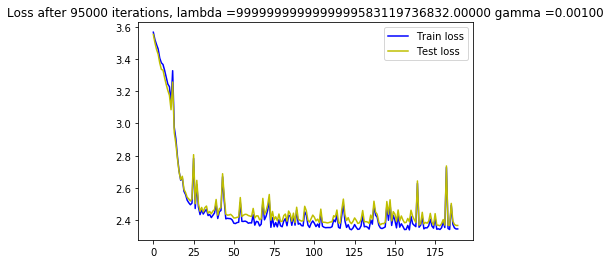

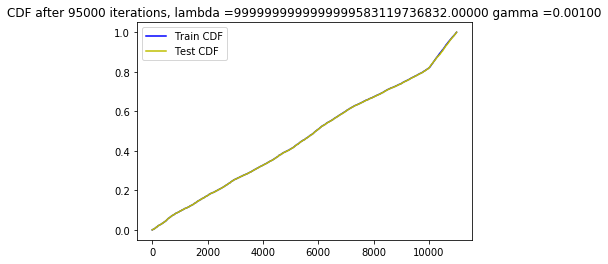

 20%|██        | 95017/473047 [57:23<31:03:19,  3.38it/s]

New score:  0.18979219
Train score:  0.3651074
Test score:  0.45991483


 21%|██        | 99993/473047 [1:00:13<1:26:38, 71.76it/s] 

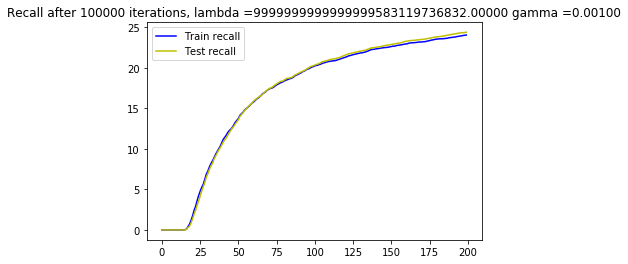

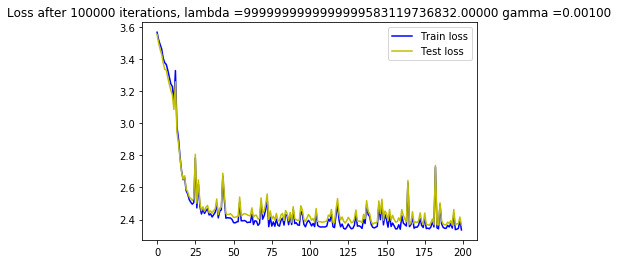

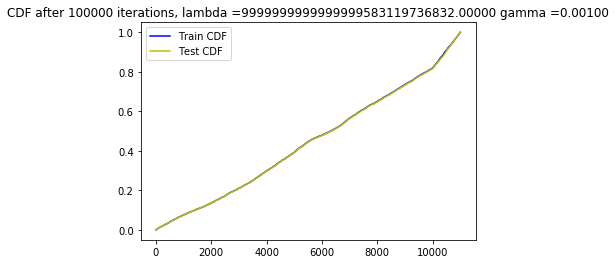

 21%|██        | 100008/473047 [1:00:25<34:42:20,  2.99it/s]

New score:  0.17828503
Train score:  0.33118773
Test score:  0.25628236


 22%|██▏       | 104995/473047 [1:03:20<1:24:22, 72.70it/s] 

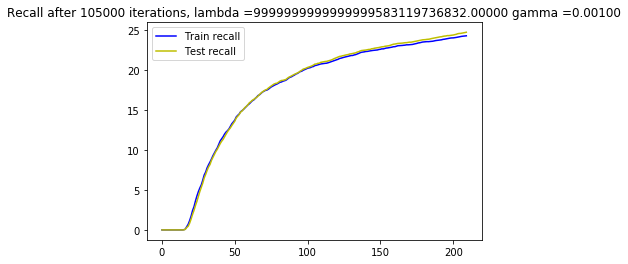

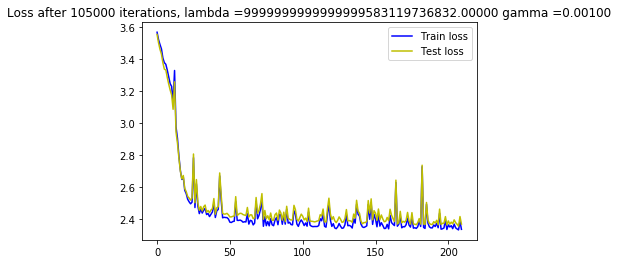

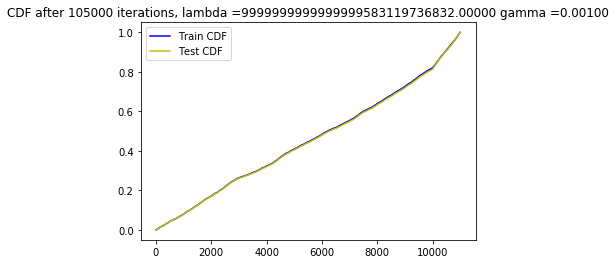

 22%|██▏       | 105011/473047 [1:03:32<34:04:47,  3.00it/s]

New score:  0.20121667
Train score:  0.3580369
Test score:  0.47024044


 23%|██▎       | 109997/473047 [1:06:27<1:22:04, 73.73it/s]  

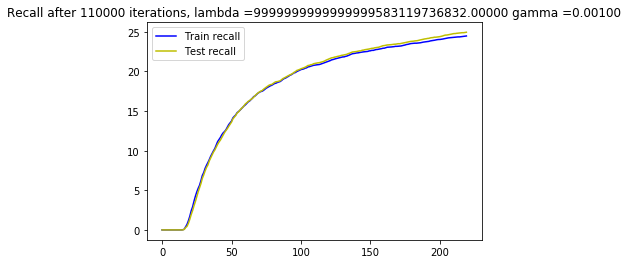

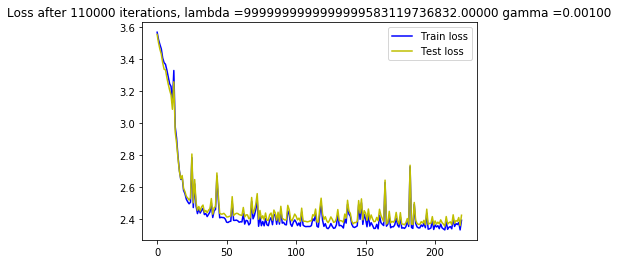

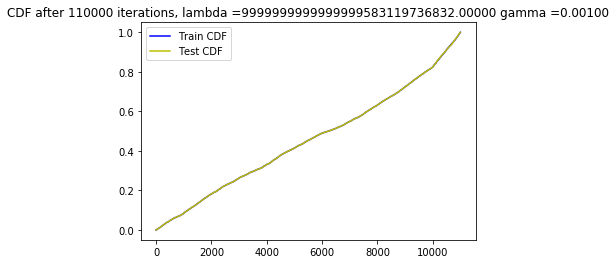

 23%|██▎       | 110013/473047 [1:06:40<33:44:25,  2.99it/s]

New score:  0.20803285
Train score:  0.47572932
Test score:  0.40523776


 24%|██▍       | 114997/473047 [1:09:34<1:17:43, 76.77it/s] 

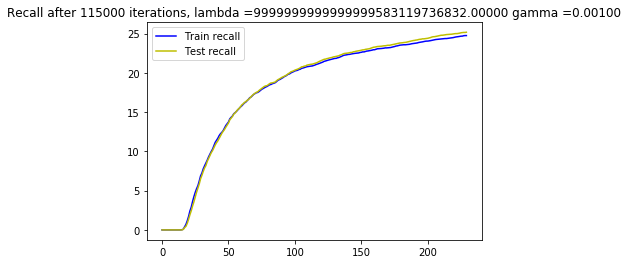

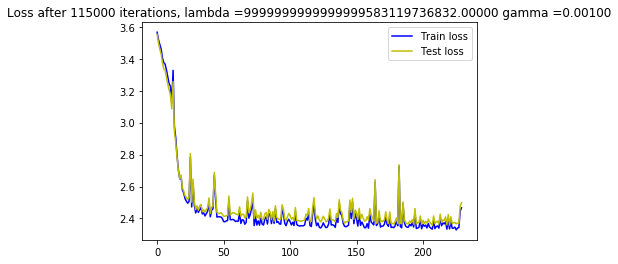

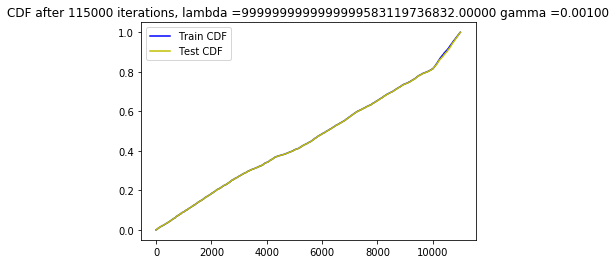

 24%|██▍       | 115013/473047 [1:09:47<33:29:59,  2.97it/s]

New score:  0.08398831
Train score:  0.29250753
Test score:  0.361439


 25%|██▌       | 119997/473047 [1:12:43<1:25:17, 68.99it/s] 

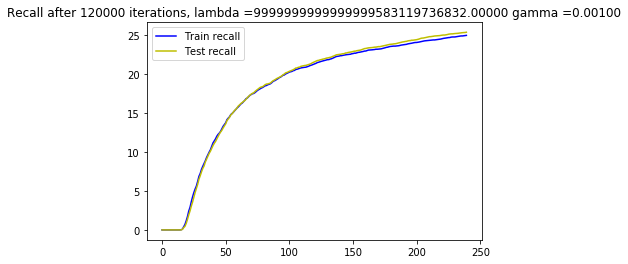

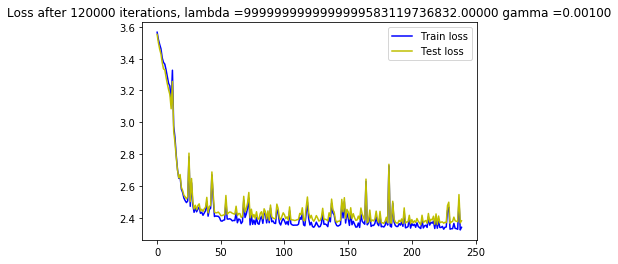

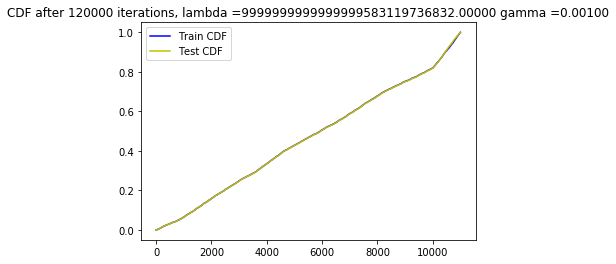

 25%|██▌       | 120012/473047 [1:12:56<37:54:31,  2.59it/s]

New score:  0.111919805
Train score:  0.37142944
Test score:  0.32960415


 26%|██▋       | 124998/473047 [1:16:00<1:17:58, 74.39it/s] 

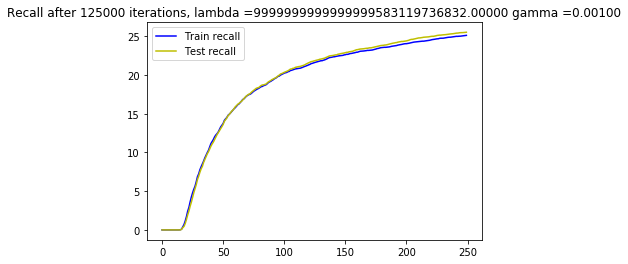

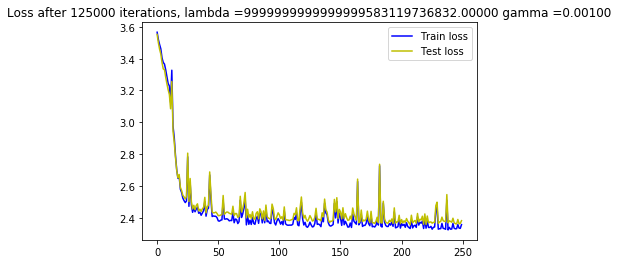

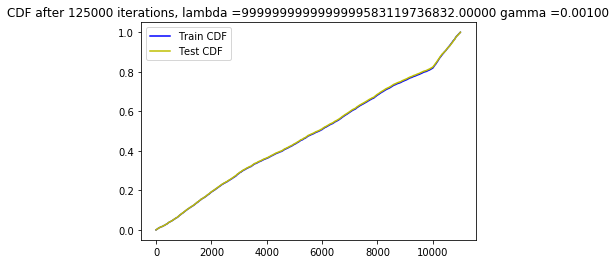

 26%|██▋       | 125009/473047 [1:16:01<84:03:01,  1.15it/s] 

New score:  0.124540746
Train score:  0.33961847
Test score:  0.41850343


 27%|██▋       | 129993/473047 [1:18:56<1:17:23, 73.88it/s] 

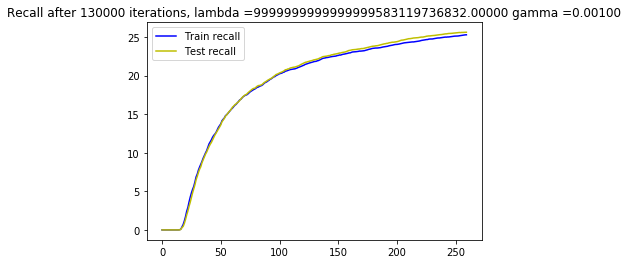

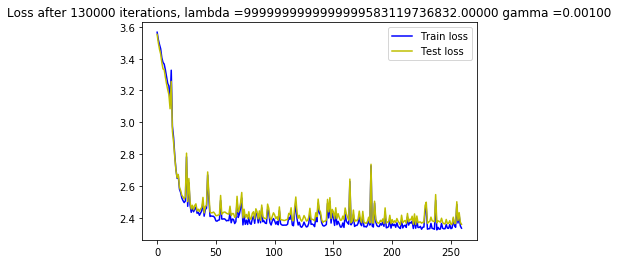

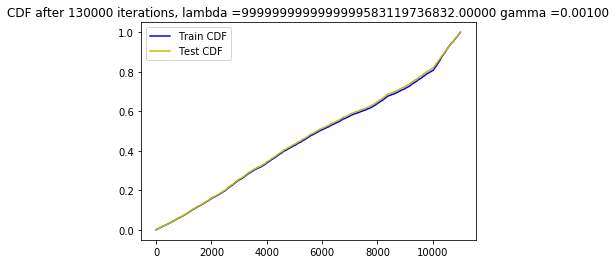

 27%|██▋       | 130009/473047 [1:19:09<32:11:57,  2.96it/s]

New score:  0.15379556
Train score:  0.3625462
Test score:  0.3501405


 29%|██▊       | 134997/473047 [1:22:04<1:17:39, 72.55it/s]  

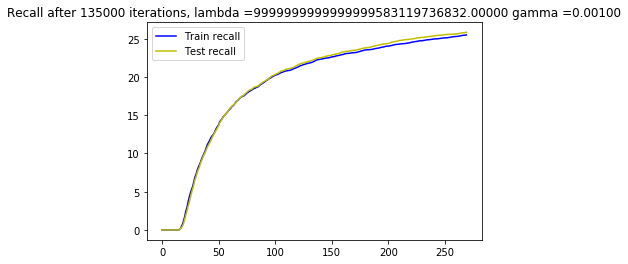

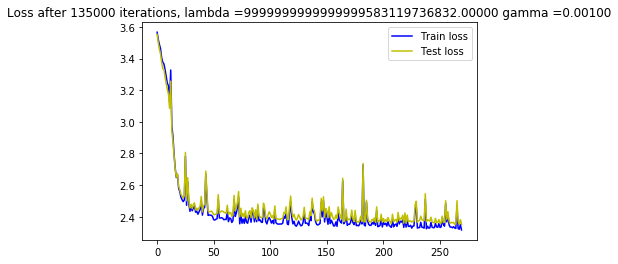

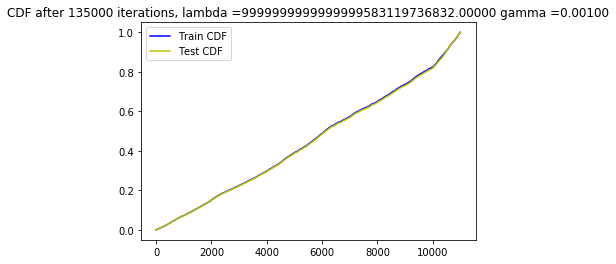

 29%|██▊       | 135013/473047 [1:22:16<31:32:24,  2.98it/s]

New score:  0.118124306
Train score:  0.33041787
Test score:  0.51029885


 30%|██▉       | 140000/473047 [1:25:12<1:17:18, 71.79it/s]  

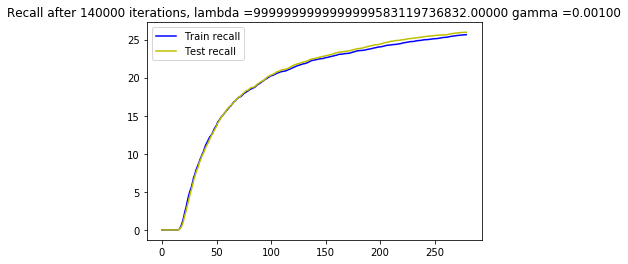

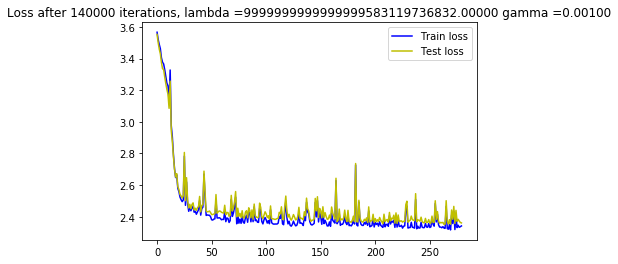

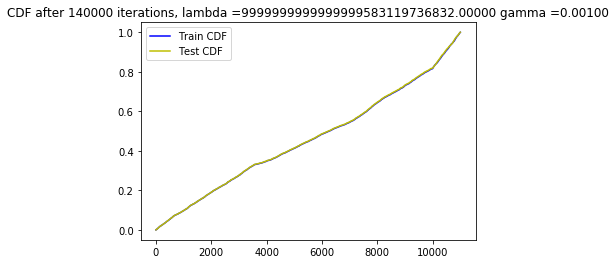

 30%|██▉       | 140008/473047 [1:25:24<43:59:01,  2.10it/s]

New score:  0.13758318
Train score:  0.3651638
Test score:  0.30907962


 31%|███       | 144996/473047 [1:28:30<1:16:38, 71.34it/s]  

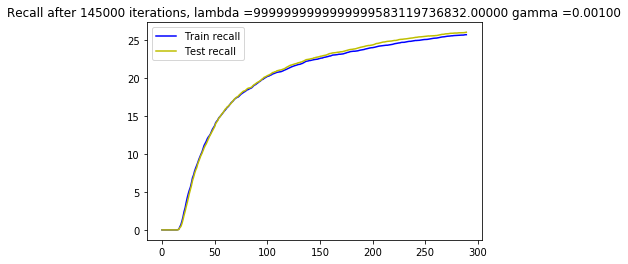

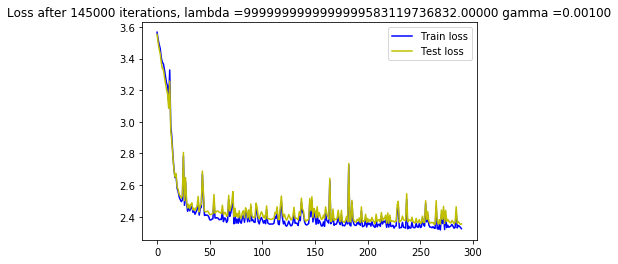

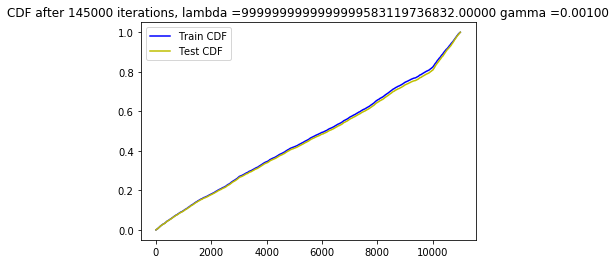

 31%|███       | 145009/473047 [1:28:32<48:25:14,  1.88it/s]

New score:  0.17510544
Train score:  0.28425452
Test score:  0.35264868


 32%|███▏      | 149997/473047 [1:31:27<1:13:25, 73.32it/s] 

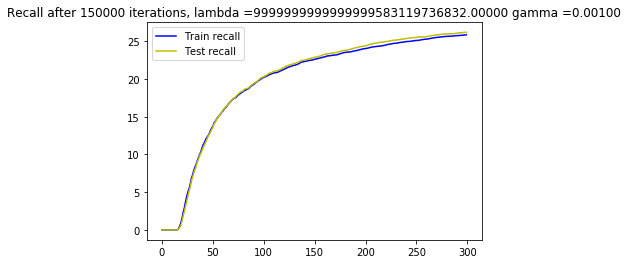

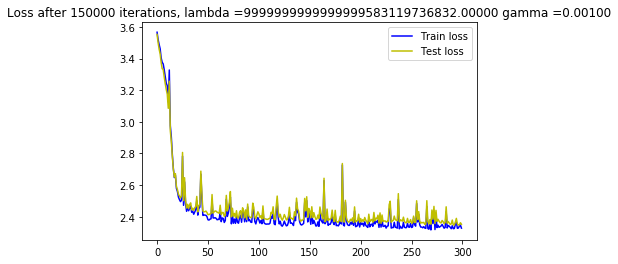

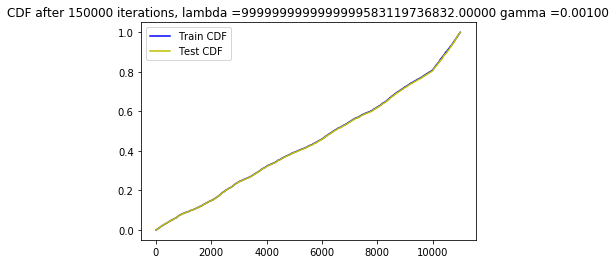

 32%|███▏      | 150013/473047 [1:31:40<30:10:31,  2.97it/s]

New score:  0.16166978
Train score:  0.3484823
Test score:  0.353611


 33%|███▎      | 154997/473047 [1:34:35<1:14:25, 71.22it/s] 

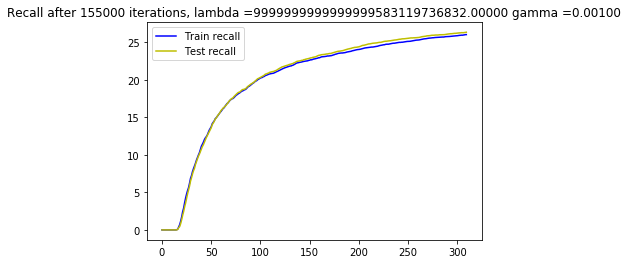

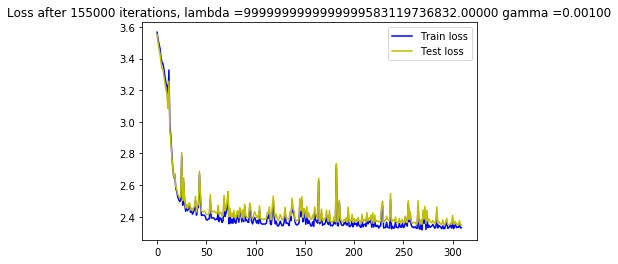

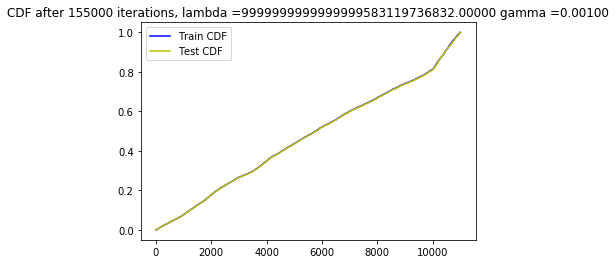

 33%|███▎      | 155013/473047 [1:34:48<30:02:12,  2.94it/s]

New score:  0.16169819
Train score:  0.31959867
Test score:  0.45474705


 34%|███▍      | 159993/473047 [1:37:44<1:12:47, 71.68it/s] 

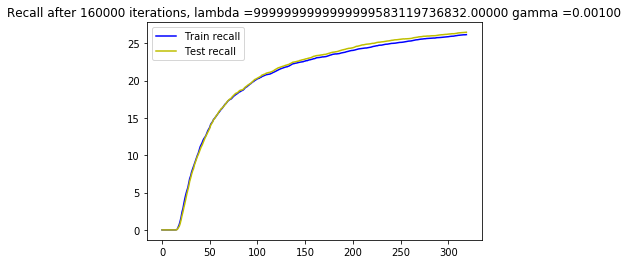

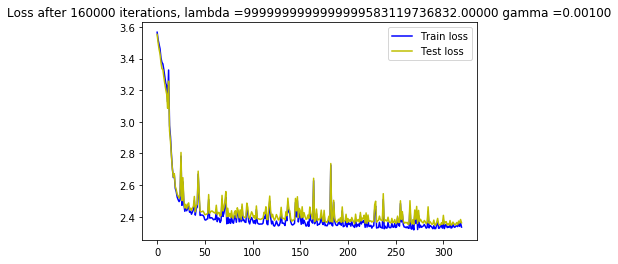

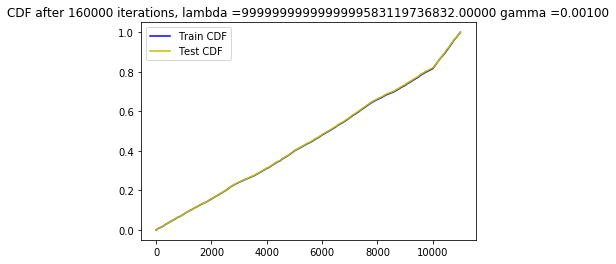

 34%|███▍      | 160009/473047 [1:37:56<29:22:44,  2.96it/s]

New score:  0.21611813
Train score:  0.48037848
Test score:  0.24201734


 35%|███▍      | 164995/473047 [1:40:51<1:08:56, 74.47it/s] 

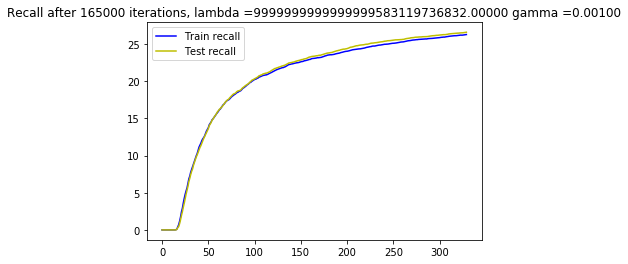

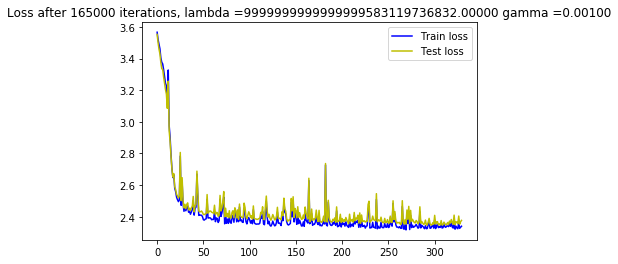

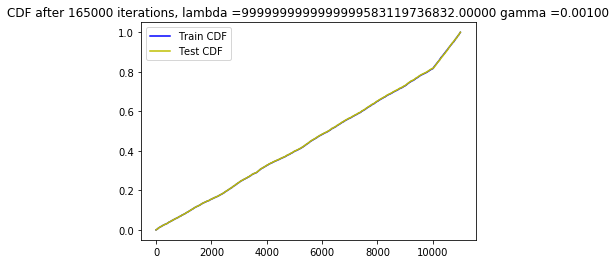

 35%|███▍      | 165011/473047 [1:41:03<28:30:57,  3.00it/s]

New score:  0.08239386
Train score:  0.5205671
Test score:  0.47441044


 36%|███▌      | 169996/473047 [1:43:58<1:10:39, 71.48it/s] 

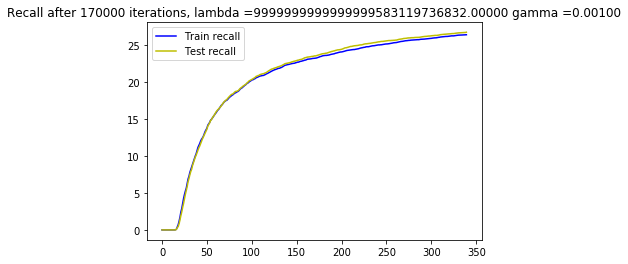

 36%|███▌      | 169996/473047 [1:44:10<1:10:39, 71.48it/s]

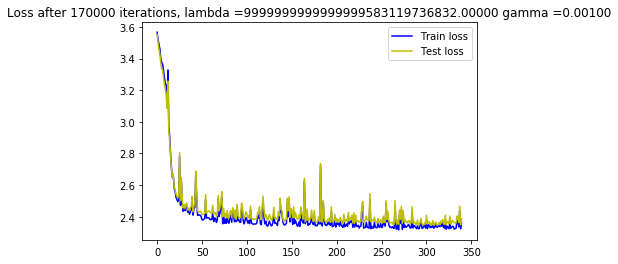

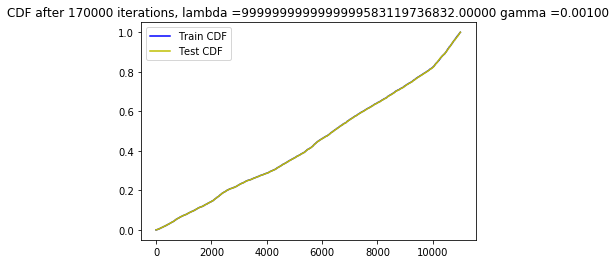

 36%|███▌      | 170008/473047 [1:44:10<44:45:42,  1.88it/s]

New score:  0.25152296
Train score:  0.32492244
Test score:  0.37599126


 37%|███▋      | 174993/473047 [1:47:05<1:08:02, 73.01it/s] 

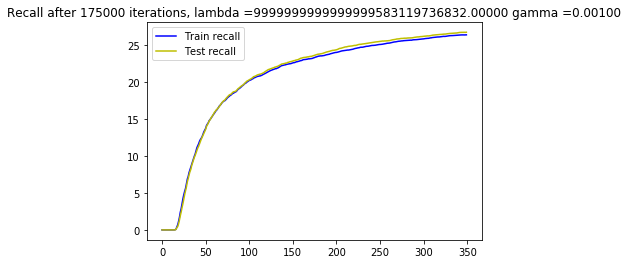

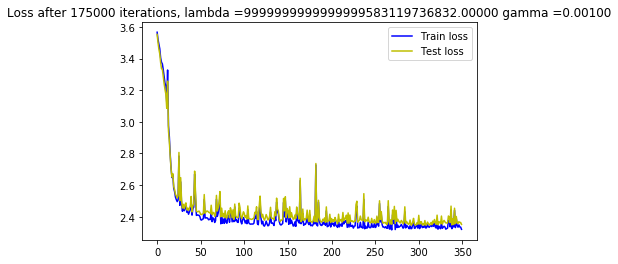

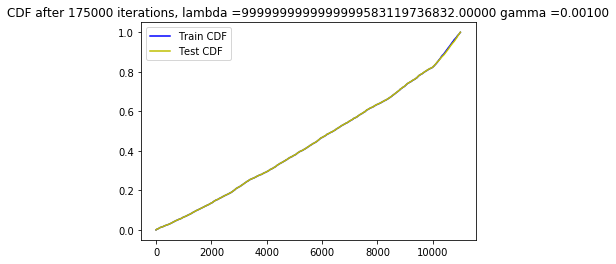

 37%|███▋      | 175009/473047 [1:47:18<28:03:15,  2.95it/s]

New score:  0.1896114
Train score:  0.42294288
Test score:  0.40688664


 38%|███▊      | 179993/473047 [1:50:13<1:06:23, 73.57it/s] 

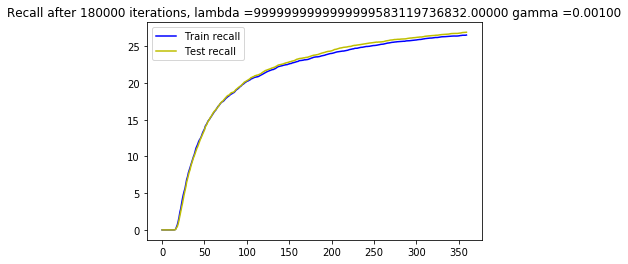

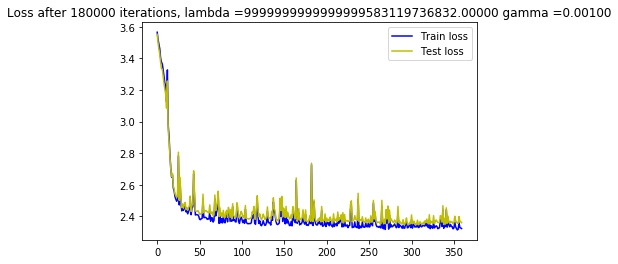

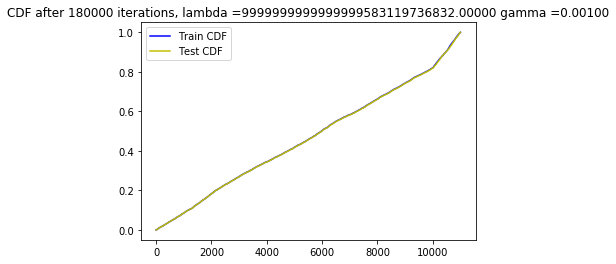

 38%|███▊      | 180009/473047 [1:50:26<27:19:55,  2.98it/s]

New score:  0.10497074
Train score:  0.37166825
Test score:  0.2605675


 39%|███▉      | 184993/473047 [1:53:21<1:05:22, 73.43it/s]  

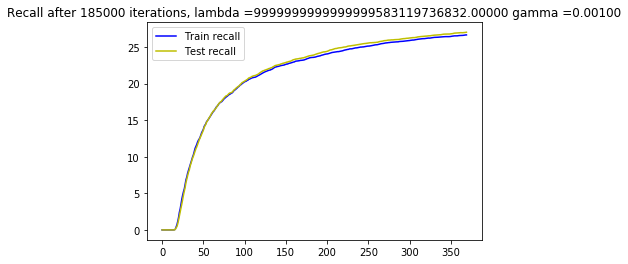

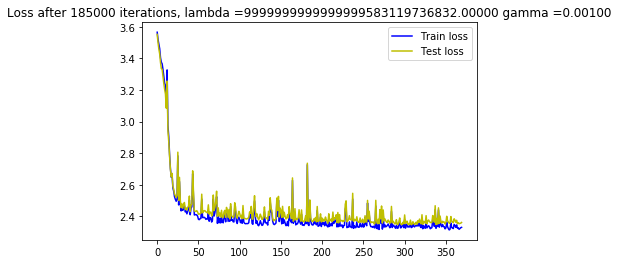

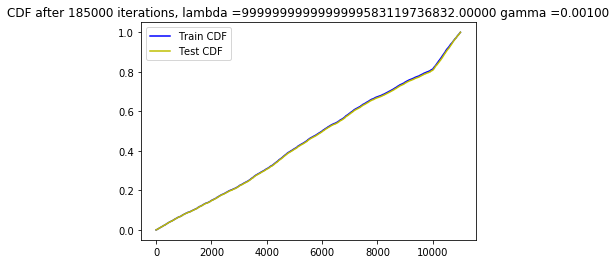

 39%|███▉      | 185009/473047 [1:53:33<27:04:54,  2.95it/s]

New score:  0.15552847
Train score:  0.34909922
Test score:  0.40974474


 40%|████      | 189997/473047 [1:56:40<1:03:56, 73.78it/s] 

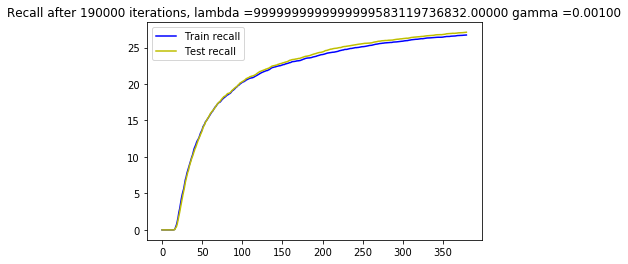

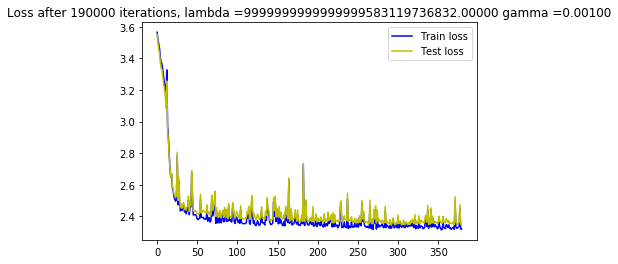

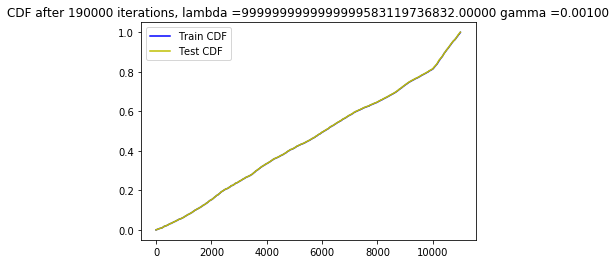

 40%|████      | 190009/473047 [1:56:40<52:13:54,  1.51it/s]

New score:  0.17315632
Train score:  0.55159545
Test score:  0.26431343


 41%|████      | 194996/473047 [1:59:34<56:21, 82.23it/s]   

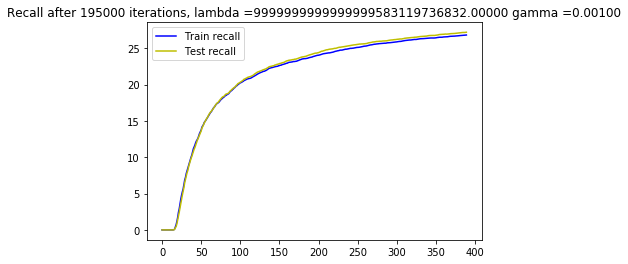

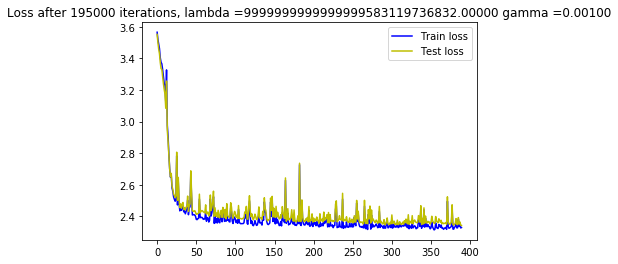

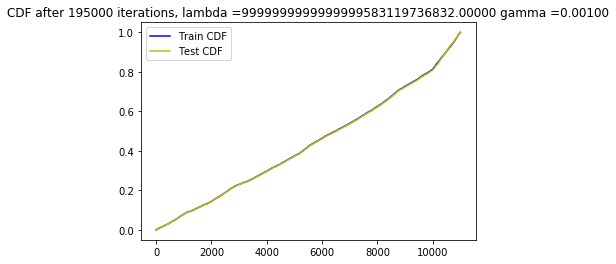

 41%|████      | 195014/473047 [1:59:46<23:10:39,  3.33it/s]

New score:  0.17999412
Train score:  0.3511274
Test score:  0.44931173


 42%|████▏     | 199995/473047 [2:02:34<55:38, 81.79it/s]    

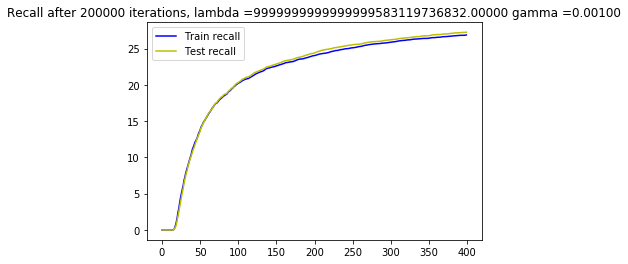

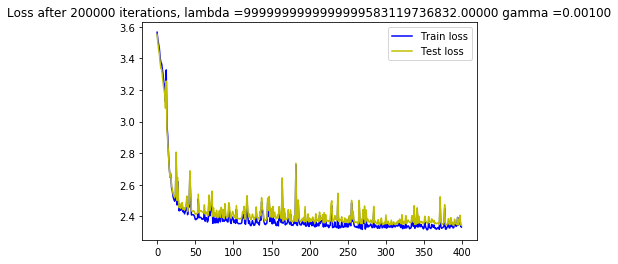

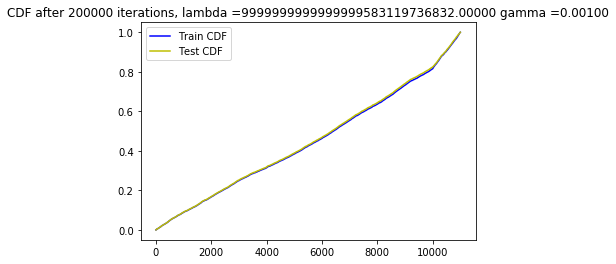

 42%|████▏     | 200012/473047 [2:02:47<22:46:52,  3.33it/s]

New score:  0.18196824
Train score:  0.40050608
Test score:  0.45806295


 43%|████▎     | 205000/473047 [2:05:35<55:55, 79.87it/s]    

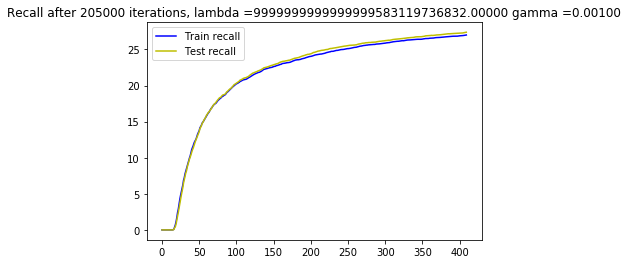

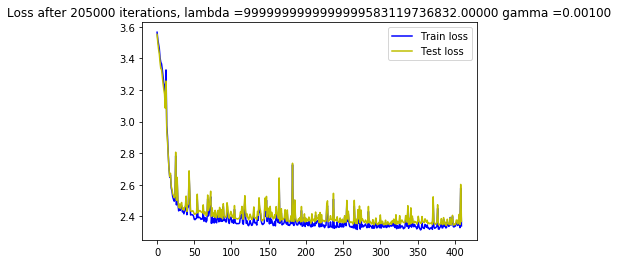

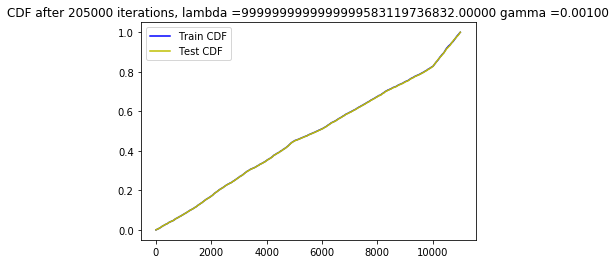

 43%|████▎     | 205017/473047 [2:05:47<24:55:02,  2.99it/s]

New score:  0.16171539
Train score:  0.33307463
Test score:  0.46361747


 44%|████▍     | 209995/473047 [2:08:50<1:01:17, 71.53it/s]  

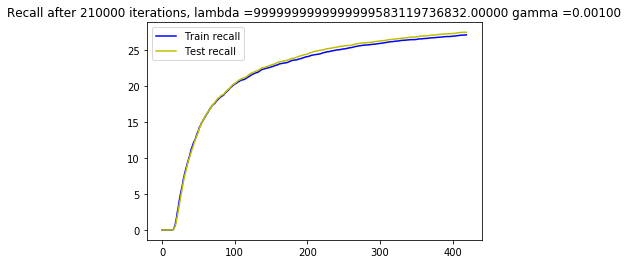

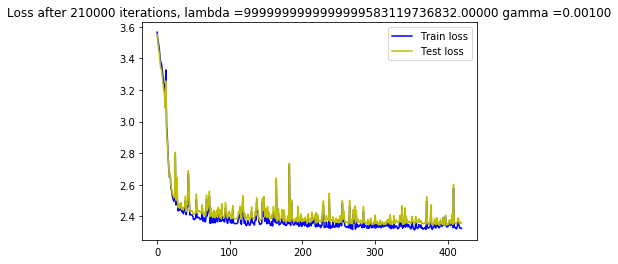

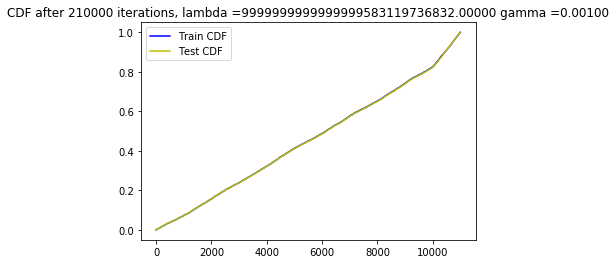

 44%|████▍     | 210009/473047 [2:08:54<35:57:54,  2.03it/s]

New score:  0.20827496
Train score:  0.3271225
Test score:  0.41042644


 45%|████▌     | 214997/473047 [2:11:47<57:14, 75.12it/s]   

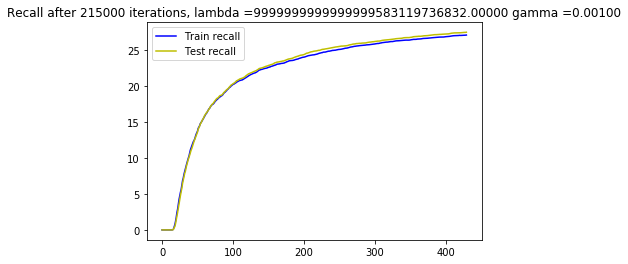

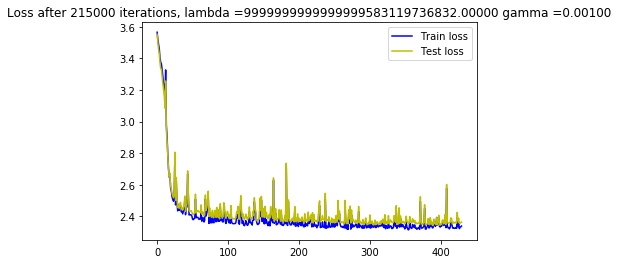

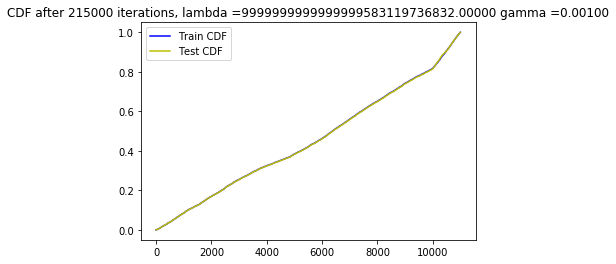

 45%|████▌     | 215013/473047 [2:12:00<23:44:06,  3.02it/s]

New score:  0.17157947
Train score:  0.33459505
Test score:  0.34923986


 47%|████▋     | 219993/473047 [2:14:52<56:11, 75.06it/s]   

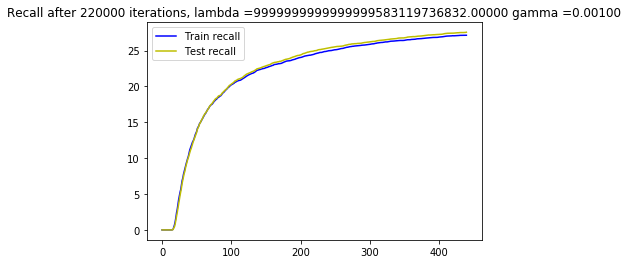

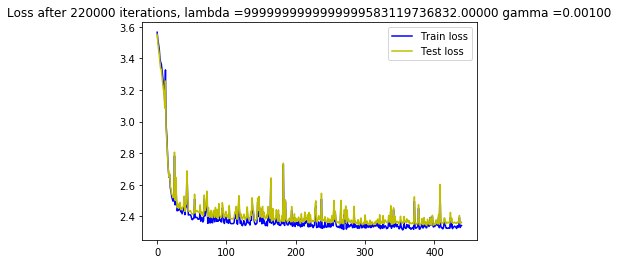

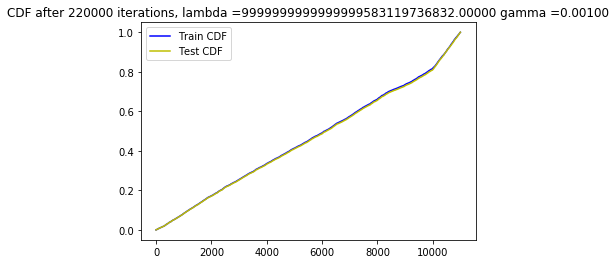

 47%|████▋     | 220009/473047 [2:15:05<23:17:48,  3.02it/s]

New score:  0.26398218
Train score:  0.3804826
Test score:  0.42447418


 48%|████▊     | 224997/473047 [2:17:57<54:37, 75.67it/s]   

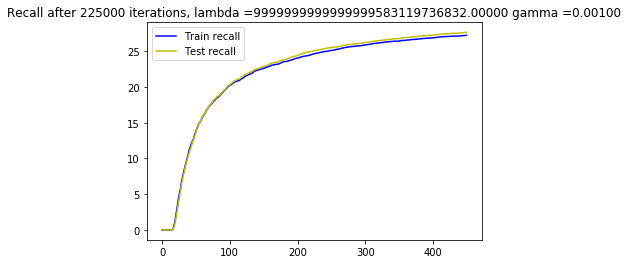

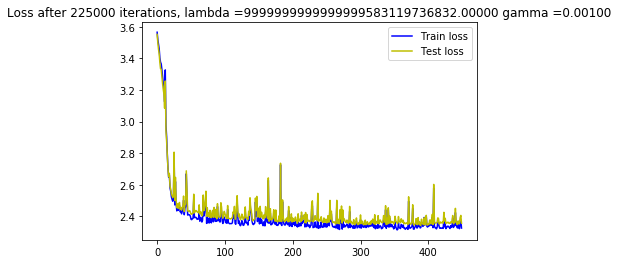

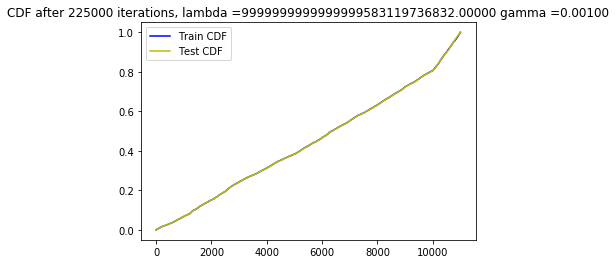

 48%|████▊     | 225013/473047 [2:18:10<22:56:03,  3.00it/s]

New score:  0.12634662
Train score:  0.45957756
Test score:  0.34195763


 49%|████▊     | 229993/473047 [2:21:03<53:55, 75.13it/s]   

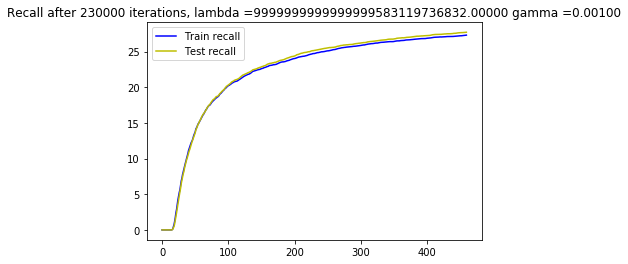

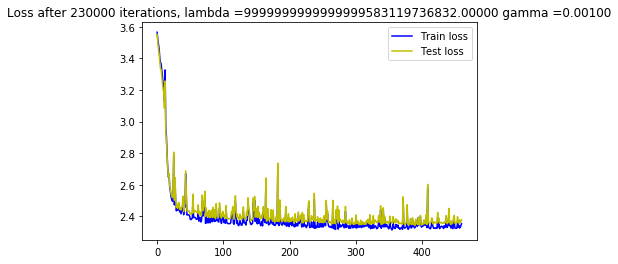

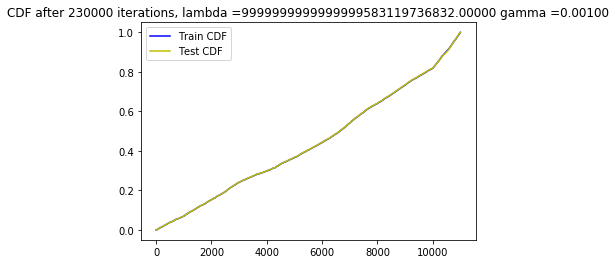

 49%|████▊     | 230009/473047 [2:21:15<22:29:19,  3.00it/s]

New score:  0.13095966
Train score:  0.5629971
Test score:  0.36017984


 50%|████▉     | 234997/473047 [2:24:20<54:41, 72.53it/s]    

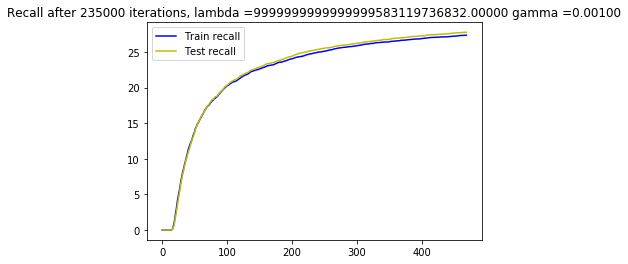

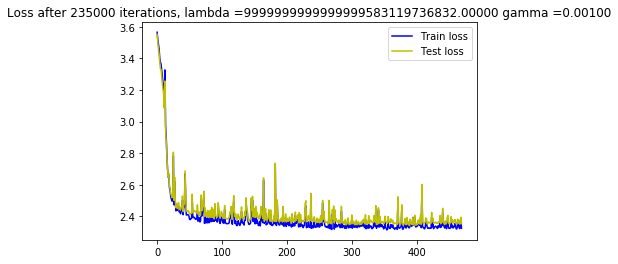

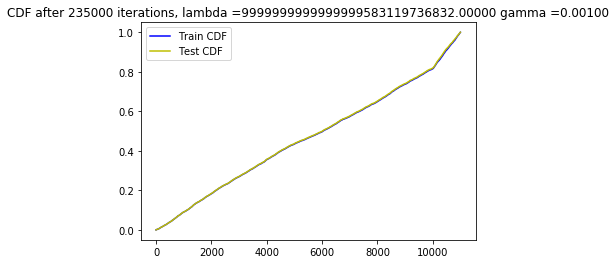

 50%|████▉     | 235009/473047 [2:24:21<43:02:17,  1.54it/s]

New score:  0.1034769
Train score:  0.43899322
Test score:  0.4394524


 51%|█████     | 239997/473047 [2:27:14<53:19, 72.84it/s]   

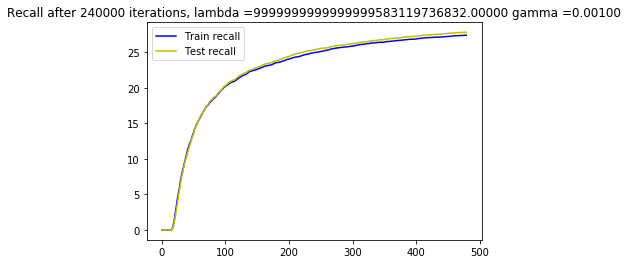

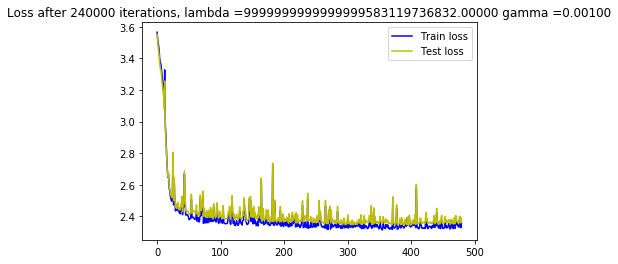

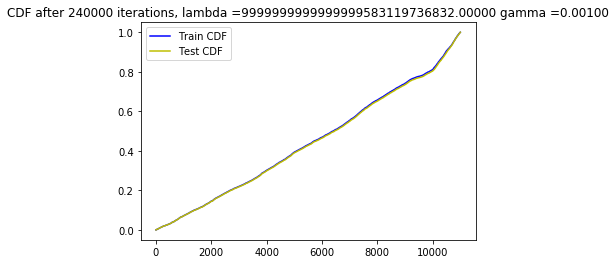

 51%|█████     | 240013/473047 [2:27:26<21:27:22,  3.02it/s]

New score:  0.12027937
Train score:  0.28476217
Test score:  0.3396903


 52%|█████▏    | 244997/473047 [2:30:30<52:24, 72.51it/s]   

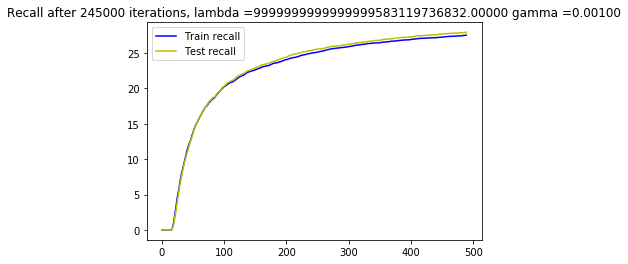

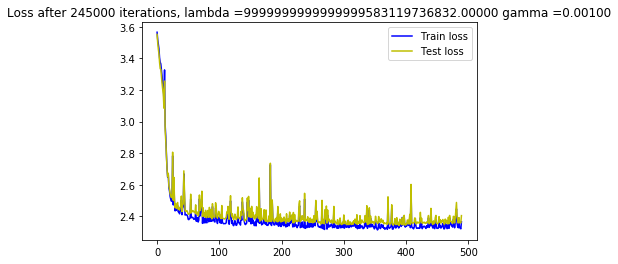

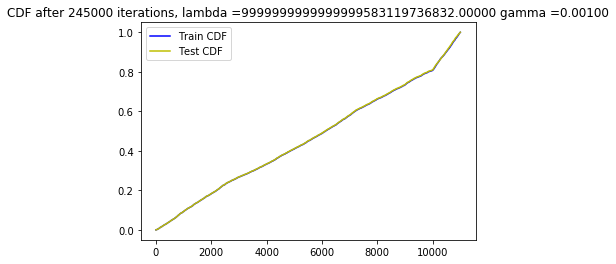

 52%|█████▏    | 245009/473047 [2:30:32<41:43:56,  1.52it/s]

New score:  0.12696926
Train score:  0.41232967
Test score:  0.32590994


 53%|█████▎    | 249997/473047 [2:33:27<50:58, 72.92it/s]   

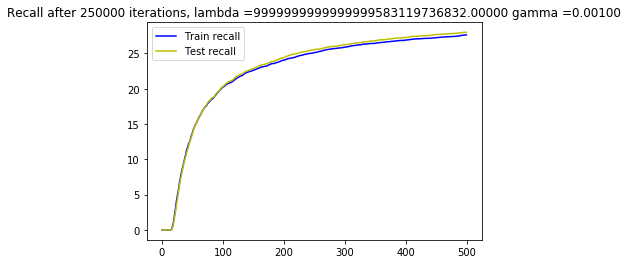

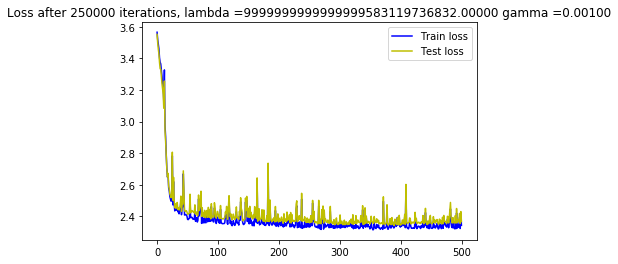

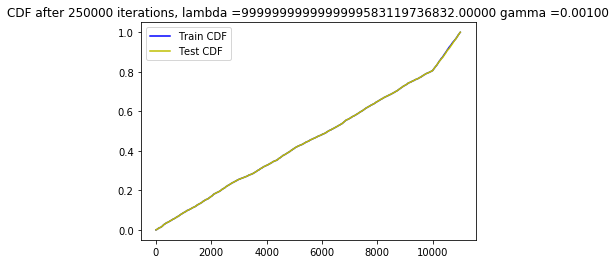

 53%|█████▎    | 250013/473047 [2:33:39<20:46:27,  2.98it/s]

New score:  0.15721841
Train score:  0.26563546
Test score:  0.25515145


 54%|█████▍    | 255000/473047 [2:36:33<49:36, 73.25it/s]   

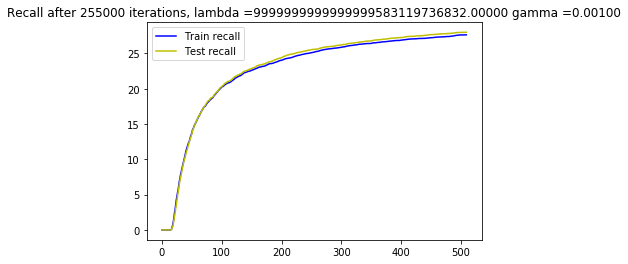

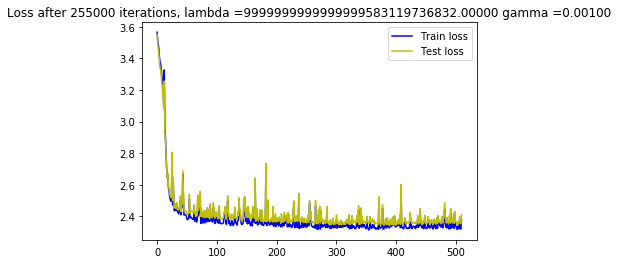

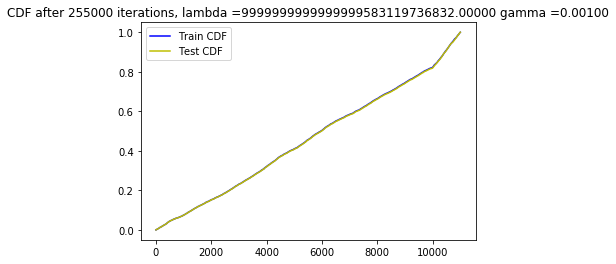

 54%|█████▍    | 255008/473047 [2:36:46<28:51:47,  2.10it/s]

New score:  0.13378914
Train score:  0.3263967
Test score:  0.3461898


 55%|█████▍    | 259993/473047 [2:39:50<49:05, 72.33it/s]   

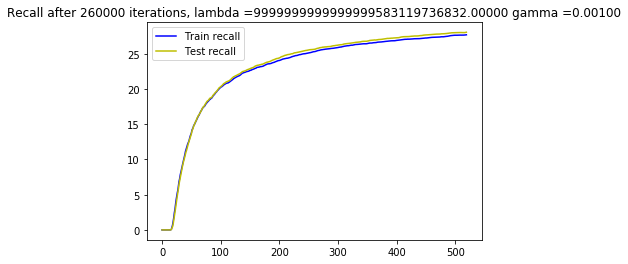

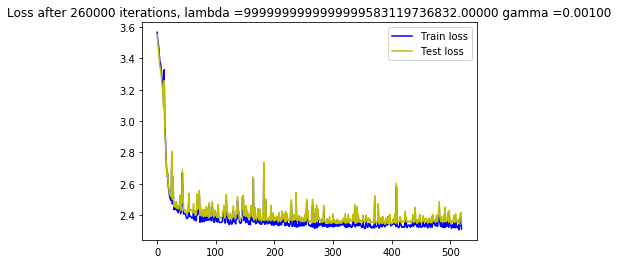

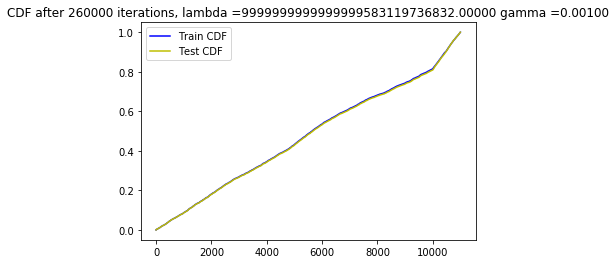

 55%|█████▍    | 260008/473047 [2:39:52<19:46:38,  2.99it/s]

New score:  0.12022165
Train score:  0.4665629
Test score:  0.42658368


 56%|█████▌    | 264993/473047 [2:42:46<46:26, 74.65it/s]   

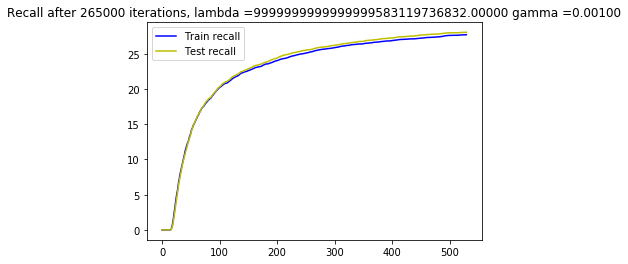

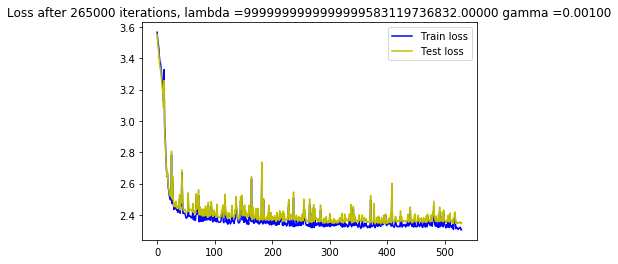

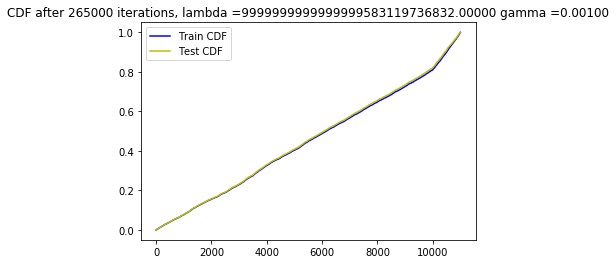

 56%|█████▌    | 265009/473047 [2:42:58<19:15:47,  3.00it/s]

New score:  0.17074198
Train score:  0.5263989
Test score:  0.28991926


 57%|█████▋    | 269997/473047 [2:45:52<46:38, 72.55it/s]   

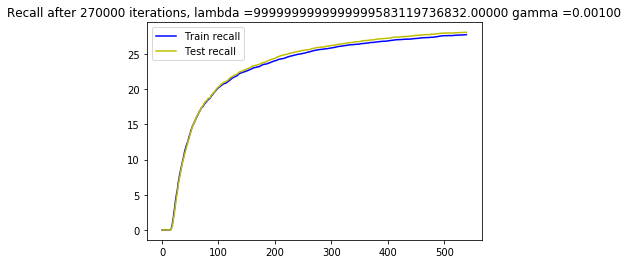

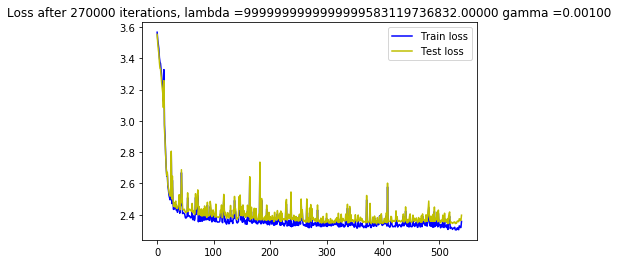

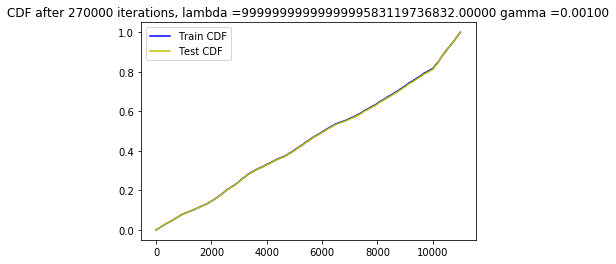

 57%|█████▋    | 270013/473047 [2:46:05<18:54:37,  2.98it/s]

New score:  0.16515474
Train score:  0.3502974
Test score:  0.35298693


 58%|█████▊    | 274997/473047 [2:49:10<45:52, 71.96it/s]    

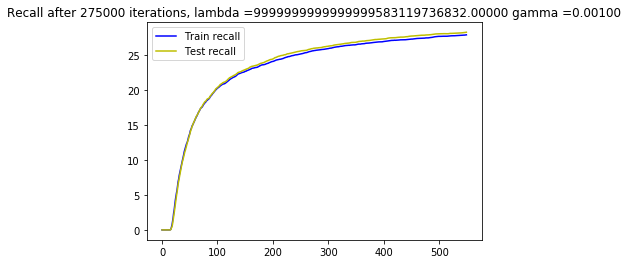

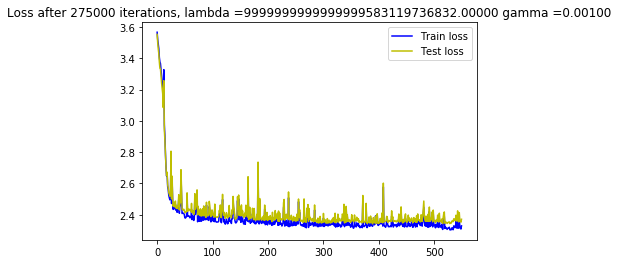

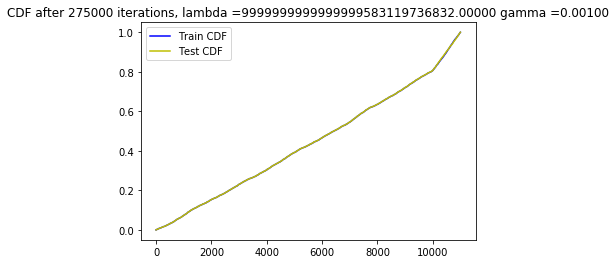

 58%|█████▊    | 275009/473047 [2:49:12<36:15:53,  1.52it/s]

New score:  0.2338489
Train score:  0.40737677
Test score:  0.4198106


 59%|█████▉    | 279993/473047 [2:52:07<44:51, 71.73it/s]   

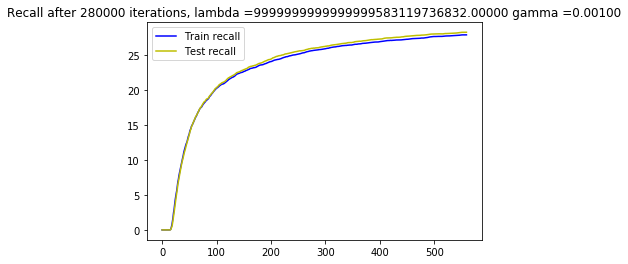

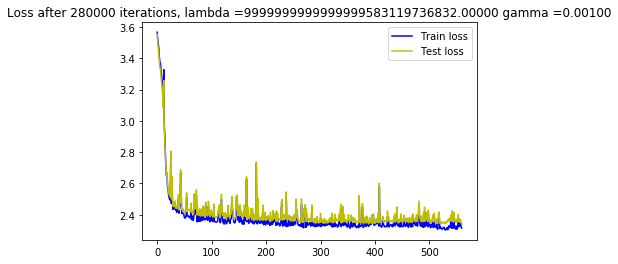

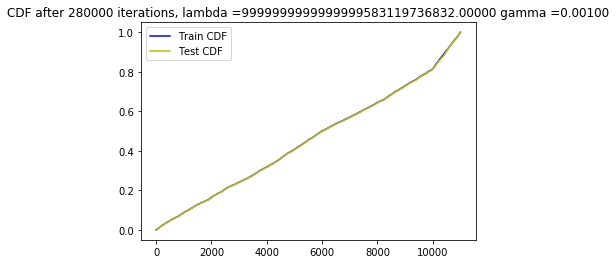

 59%|█████▉    | 280009/473047 [2:52:19<18:07:07,  2.96it/s]

New score:  0.1283116
Train score:  0.37451345
Test score:  0.3677123


 60%|██████    | 284997/473047 [2:55:13<41:59, 74.65it/s]   

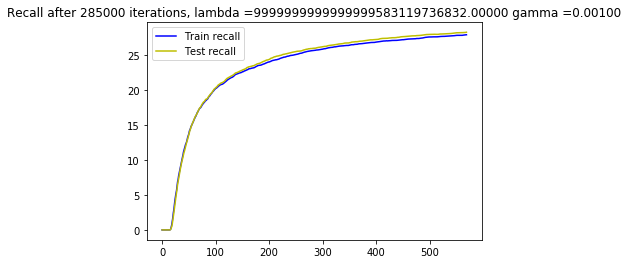

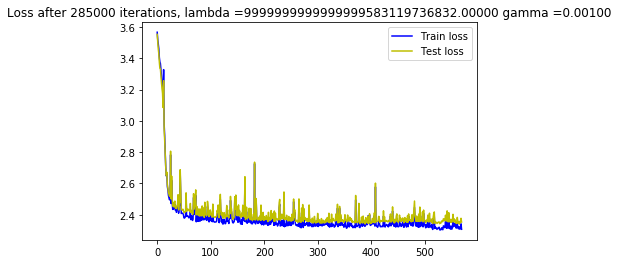

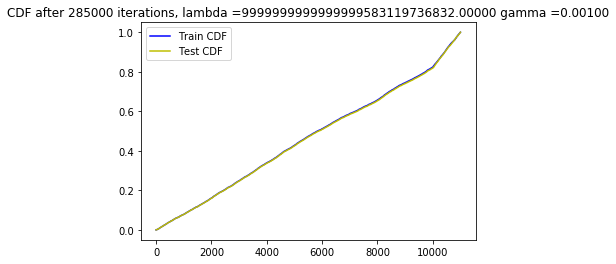

 60%|██████    | 285013/473047 [2:55:26<17:37:25,  2.96it/s]

New score:  0.15798421
Train score:  0.4617467
Test score:  0.48019257


 61%|██████▏   | 289996/473047 [2:58:17<37:48, 80.68it/s]   

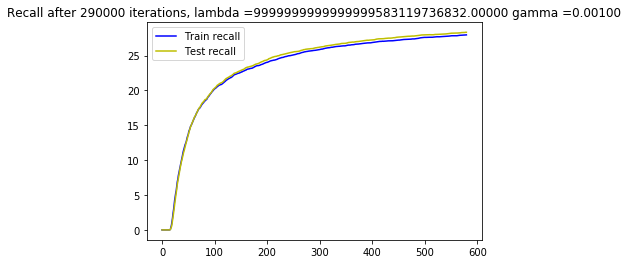

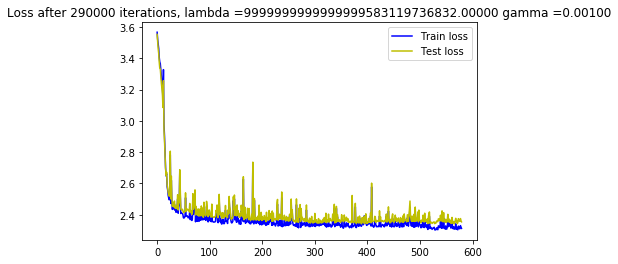

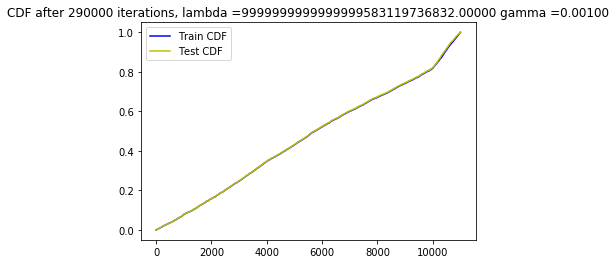

 61%|██████▏   | 290014/473047 [2:58:29<15:10:48,  3.35it/s]

New score:  0.27529436
Train score:  0.4695614
Test score:  0.37743595


 62%|██████▏   | 294996/473047 [3:01:17<35:33, 83.47it/s]   

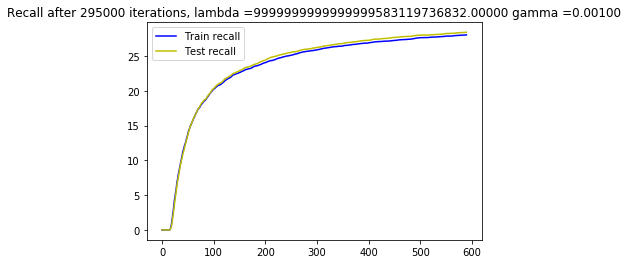

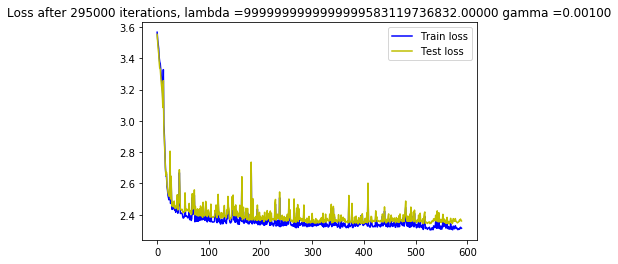

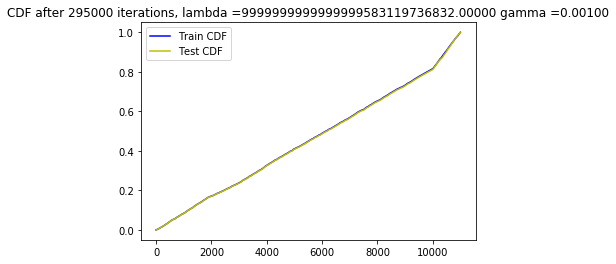

 62%|██████▏   | 295014/473047 [3:01:29<14:50:06,  3.33it/s]

New score:  0.1576541
Train score:  0.44818917
Test score:  0.23860708


 63%|██████▎   | 299999/473047 [3:04:17<39:26, 73.13it/s]   

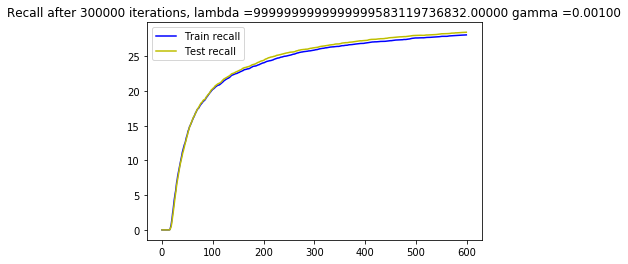

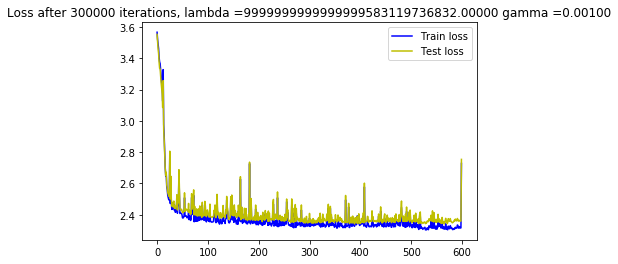

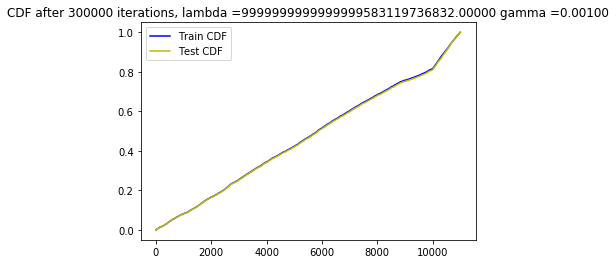

 63%|██████▎   | 300015/473047 [3:04:30<16:13:22,  2.96it/s]

New score:  0.09909208
Train score:  0.41752863
Test score:  0.190902


 64%|██████▍   | 304995/473047 [3:07:23<34:14, 81.78it/s]   

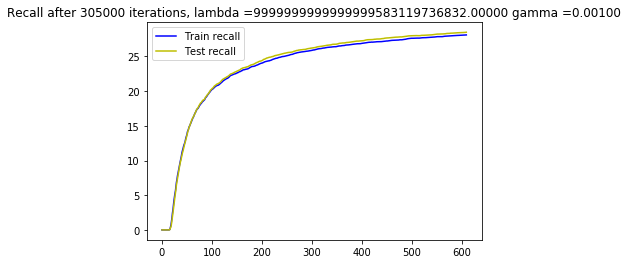

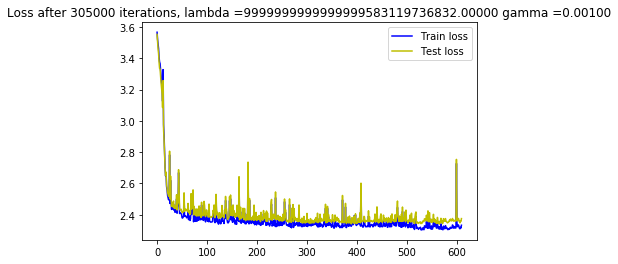

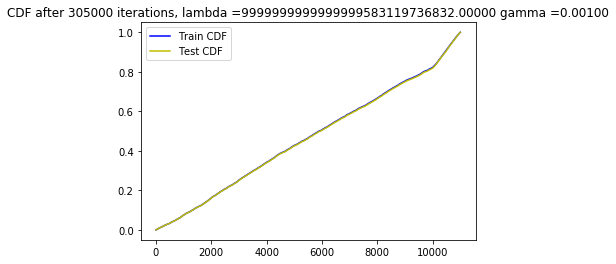

 64%|██████▍   | 305013/473047 [3:07:35<13:59:53,  3.33it/s]

New score:  0.118094504
Train score:  0.25878888
Test score:  0.411402


 66%|██████▌   | 309994/473047 [3:10:24<36:10, 75.11it/s]   

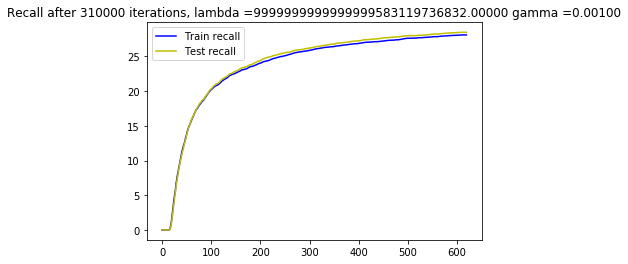

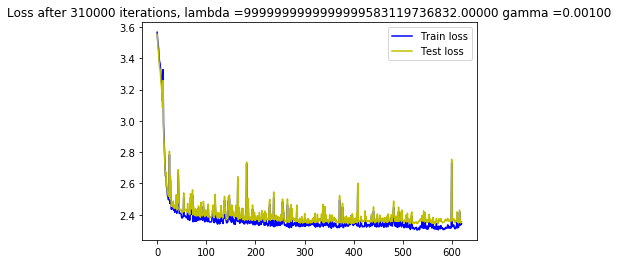

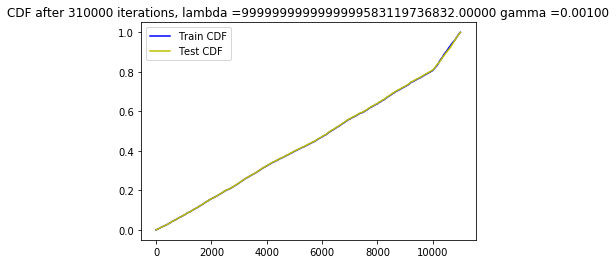

 66%|██████▌   | 310010/473047 [3:10:36<15:01:46,  3.01it/s]

New score:  0.12304582
Train score:  0.31339115
Test score:  0.40269366


 67%|██████▋   | 314997/473047 [3:13:40<35:46, 73.63it/s]   

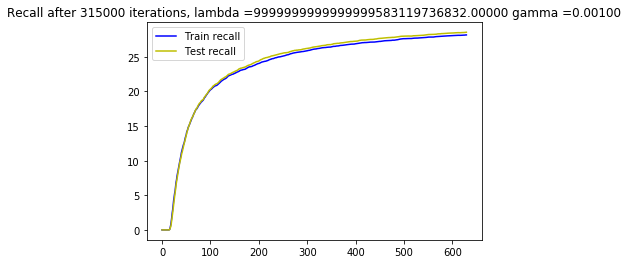

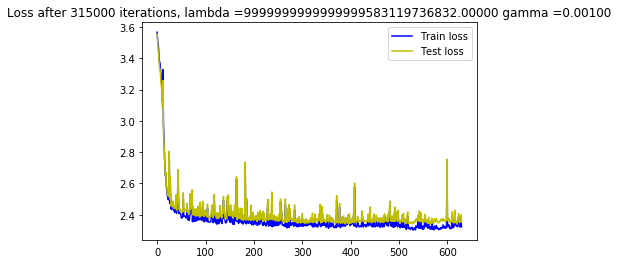

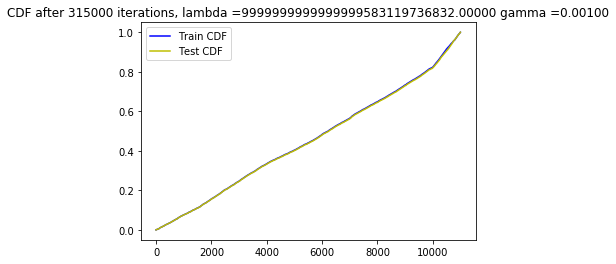

 67%|██████▋   | 315009/473047 [3:13:41<28:39:58,  1.53it/s]

New score:  0.19629678
Train score:  0.47258702
Test score:  0.5023531


 68%|██████▊   | 319999/473047 [3:16:30<29:59, 85.05it/s]   

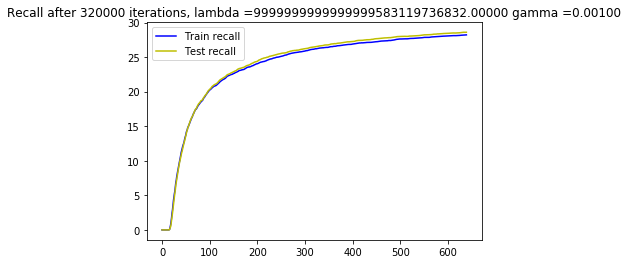

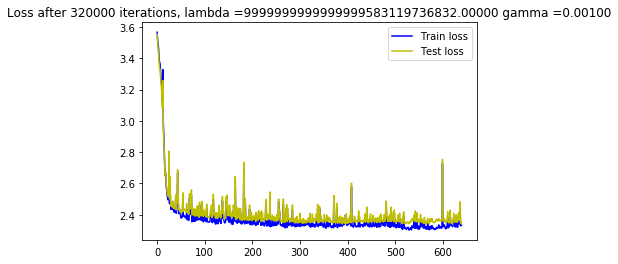

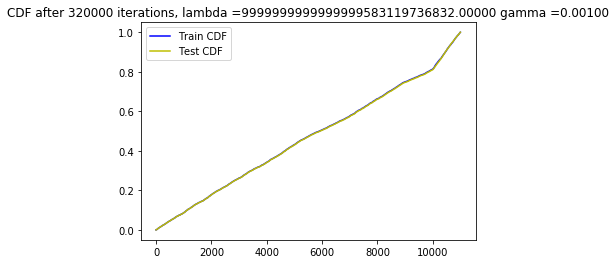

 68%|██████▊   | 320017/473047 [3:16:42<12:32:41,  3.39it/s]

New score:  0.09862646
Train score:  0.4098877
Test score:  0.3212337


 69%|██████▊   | 324997/473047 [3:19:31<33:16, 74.16it/s]   

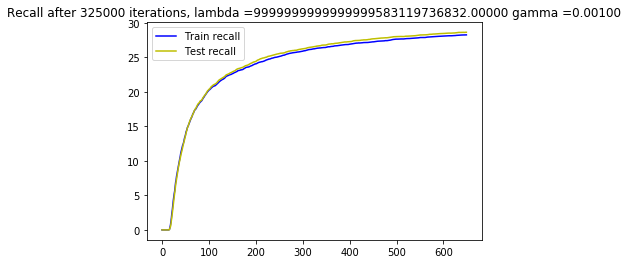

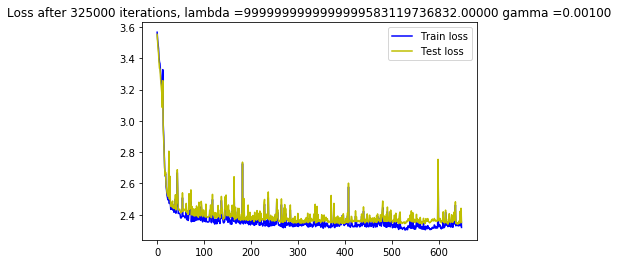

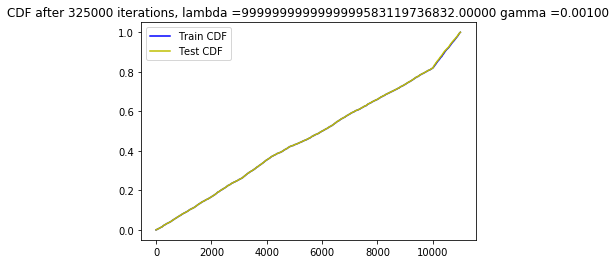

 69%|██████▊   | 325013/473047 [3:19:43<13:45:30,  2.99it/s]

New score:  0.123953775
Train score:  0.2779501
Test score:  0.30896726


 70%|██████▉   | 329993/473047 [3:22:37<32:08, 74.19it/s]   

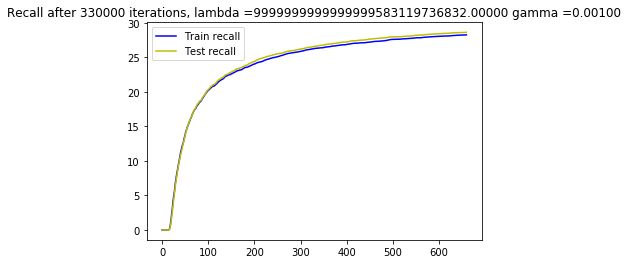

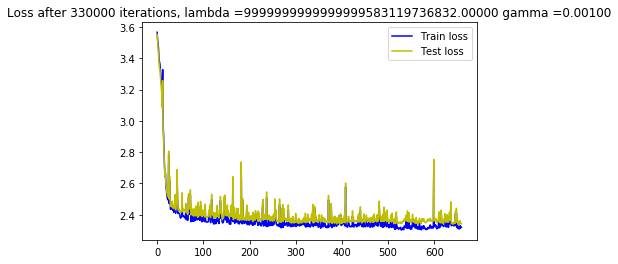

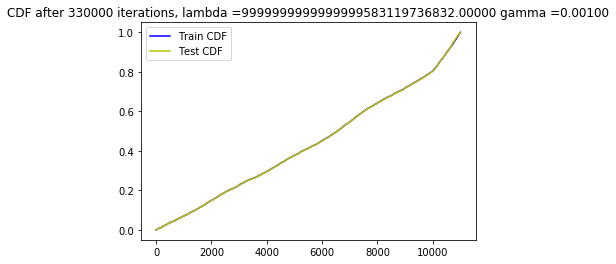

 70%|██████▉   | 330009/473047 [3:22:49<13:16:27,  2.99it/s]

New score:  0.1297831
Train score:  0.4305064
Test score:  0.3248678


 71%|███████   | 334993/473047 [3:25:42<31:19, 73.46it/s]   

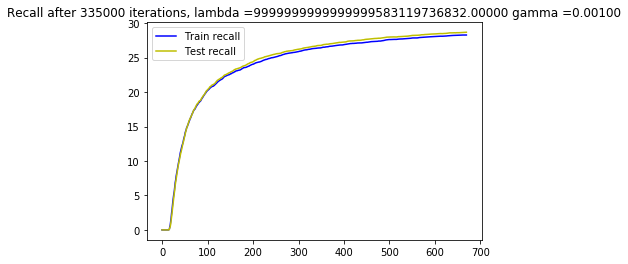

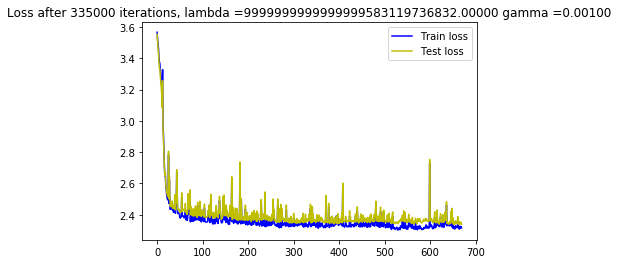

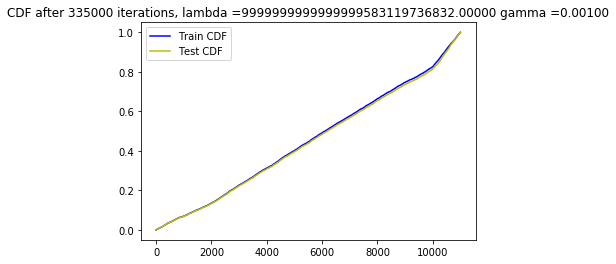

 71%|███████   | 335009/473047 [3:25:55<12:47:11,  3.00it/s]

New score:  0.20758533
Train score:  0.4002727
Test score:  0.4307754


 72%|███████▏  | 339994/473047 [3:29:00<30:25, 72.87it/s]   

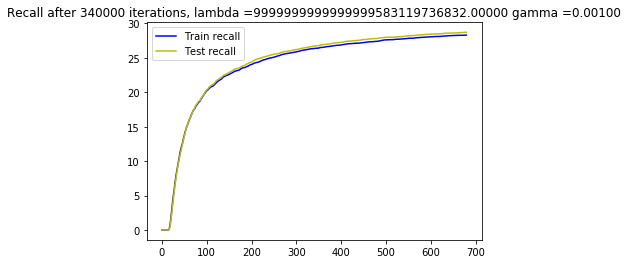

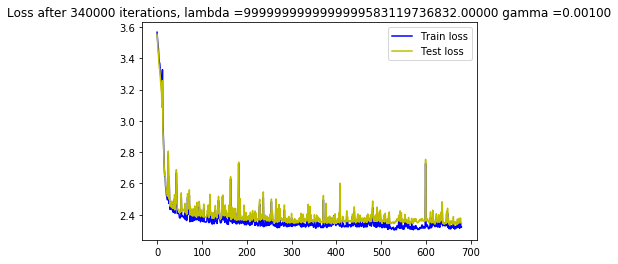

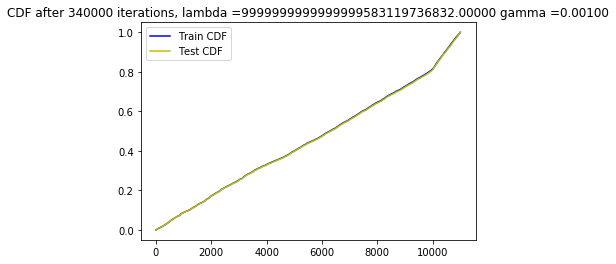

 72%|███████▏  | 340008/473047 [3:29:01<14:01:36,  2.63it/s]

New score:  0.24364655
Train score:  0.46262327
Test score:  0.4409573


 73%|███████▎  | 344993/473047 [3:31:56<29:09, 73.19it/s]    

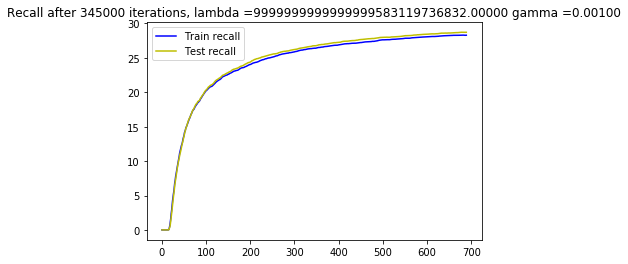

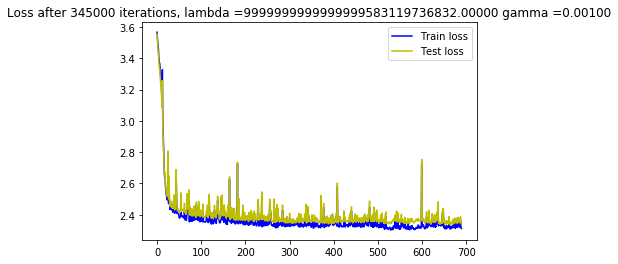

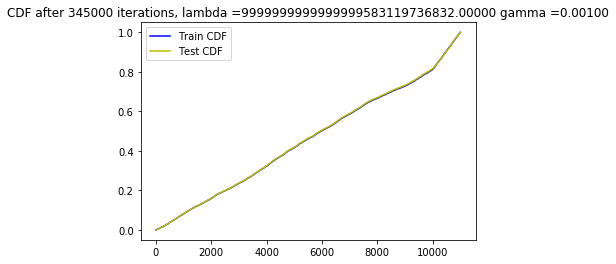

 73%|███████▎  | 345009/473047 [3:32:09<11:59:48,  2.96it/s]

New score:  0.12830009
Train score:  0.39127406
Test score:  0.36531478


 74%|███████▍  | 350000/473047 [3:35:04<27:57, 73.36it/s]   

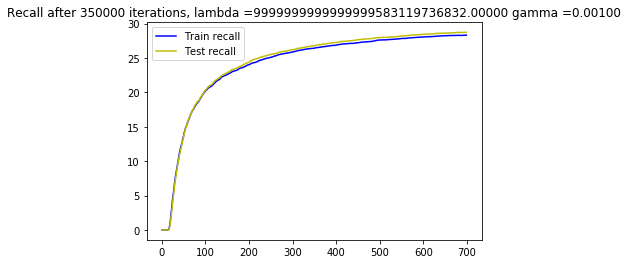

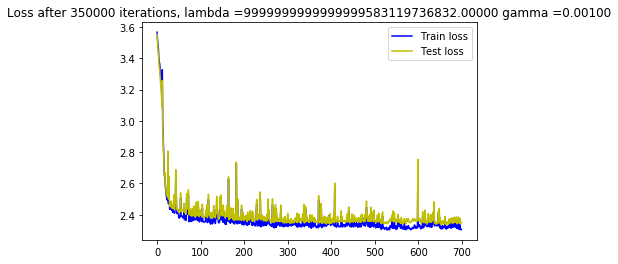

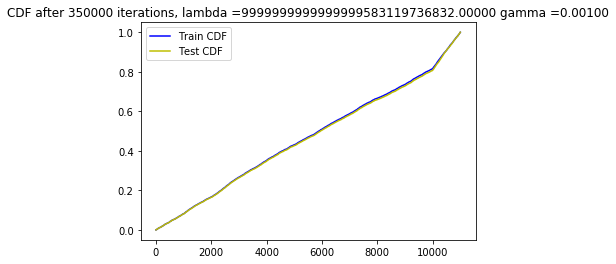

 74%|███████▍  | 350008/473047 [3:35:17<16:20:52,  2.09it/s]

New score:  0.2423605
Train score:  0.47787276
Test score:  0.53625333


 75%|███████▌  | 354997/473047 [3:38:12<26:44, 73.56it/s]    

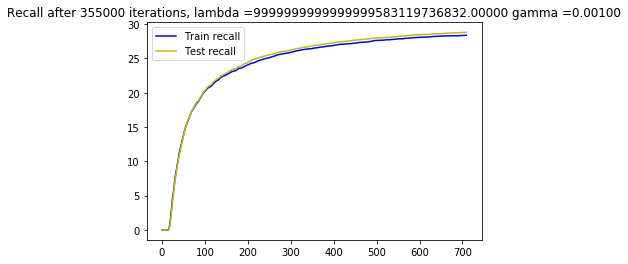

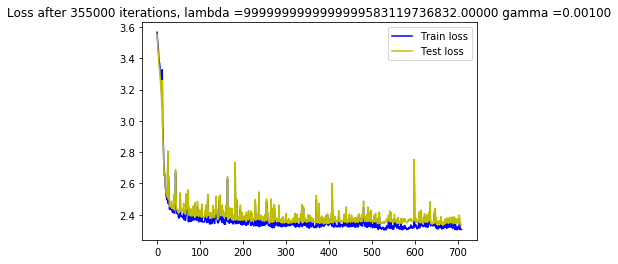

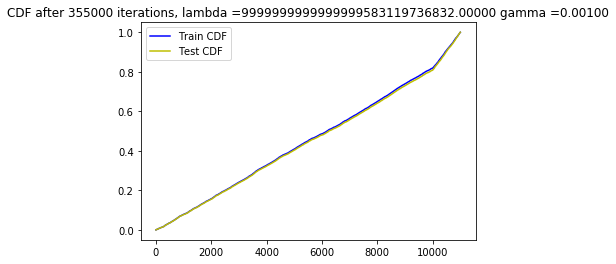

 75%|███████▌  | 355013/473047 [3:38:25<11:07:27,  2.95it/s]

New score:  0.0889356
Train score:  0.47976023
Test score:  0.3892802


 76%|███████▌  | 359999/473047 [3:41:21<27:11, 69.27it/s]    

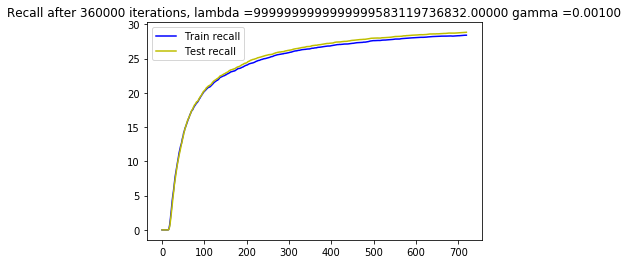

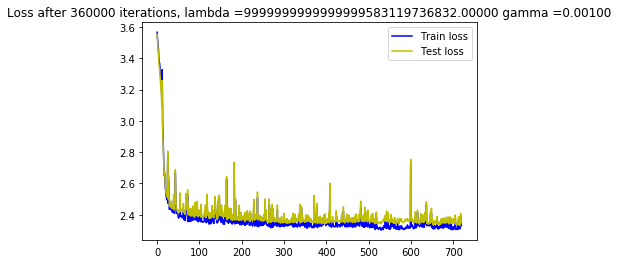

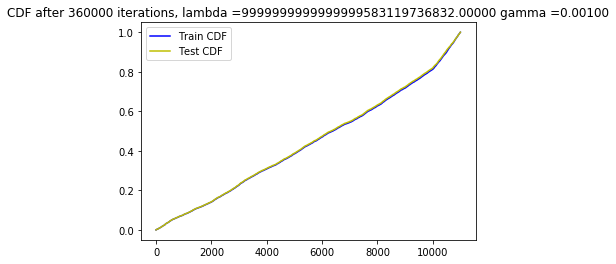

 76%|███████▌  | 360013/473047 [3:41:35<12:48:06,  2.45it/s]

New score:  0.20336993
Train score:  0.40343753
Test score:  0.39284796


 77%|███████▋  | 364997/473047 [3:44:35<24:50, 72.49it/s]   

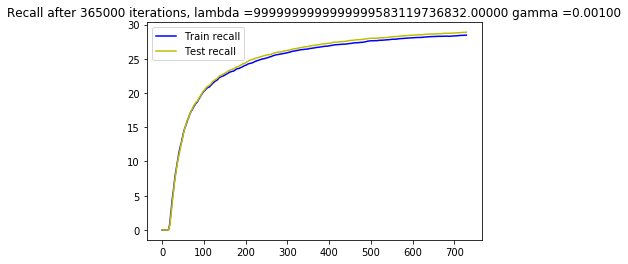

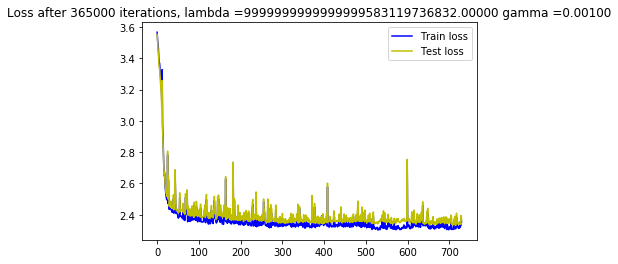

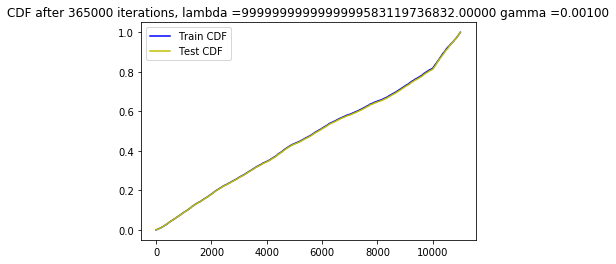

 77%|███████▋  | 365013/473047 [3:44:48<10:08:27,  2.96it/s]

New score:  0.20239155
Train score:  0.51468027
Test score:  0.4545535


 78%|███████▊  | 369998/473047 [3:47:43<23:28, 73.17it/s]    

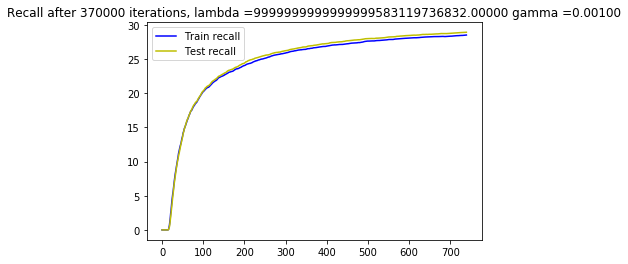

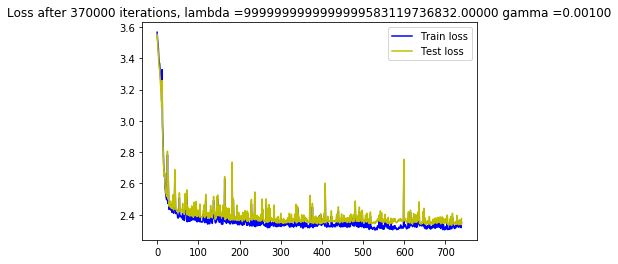

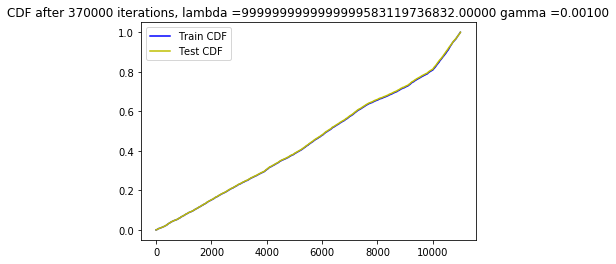

 78%|███████▊  | 370014/473047 [3:47:55<9:39:13,  2.96it/s] 

New score:  0.0845739
Train score:  0.43087602
Test score:  0.6340899


 79%|███████▉  | 374996/473047 [3:51:00<22:23, 72.98it/s]   

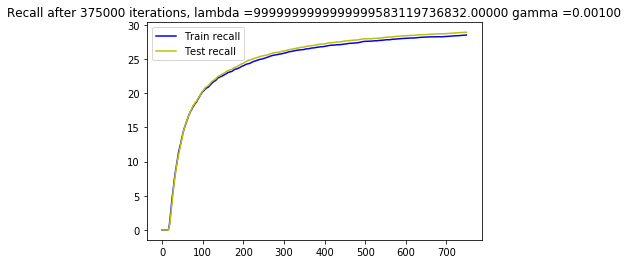

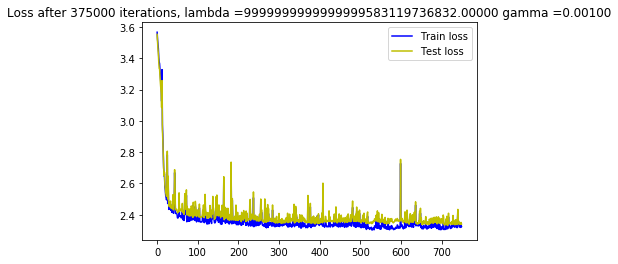

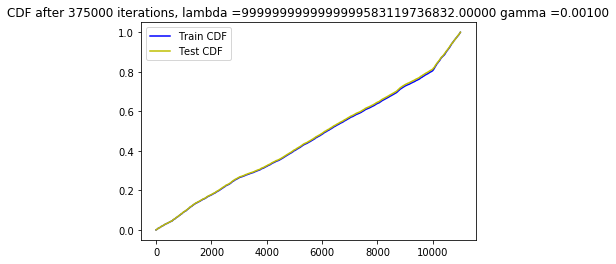

 79%|███████▉  | 375008/473047 [3:51:03<14:30:37,  1.88it/s]

New score:  0.19786751
Train score:  0.5137116
Test score:  0.50418407


 80%|████████  | 379997/473047 [3:54:10<21:48, 71.13it/s]   

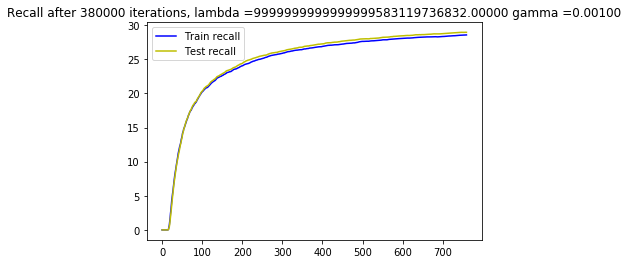

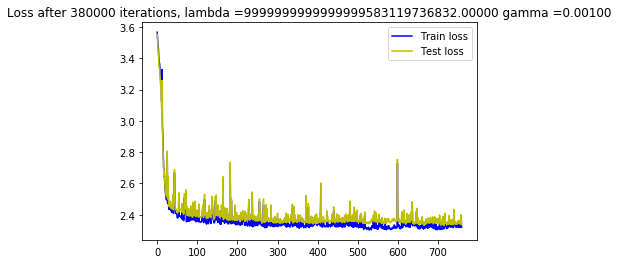

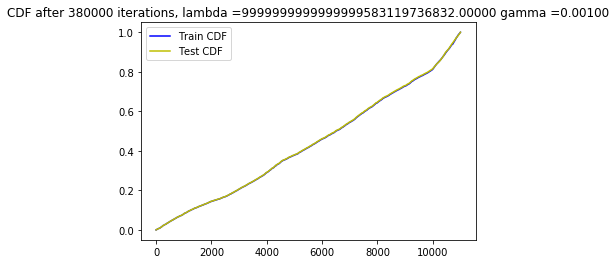

 80%|████████  | 380009/473047 [3:54:12<17:11:58,  1.50it/s]

New score:  0.24903011
Train score:  0.41651195
Test score:  0.42048773


 81%|████████▏ | 384997/473047 [3:57:20<20:31, 71.53it/s]   

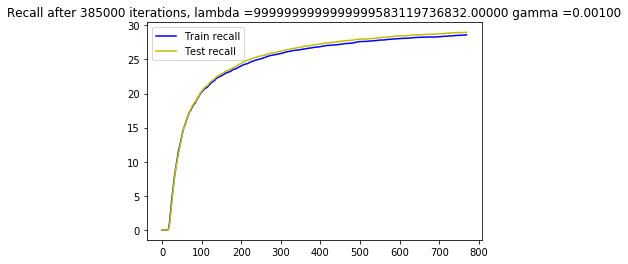

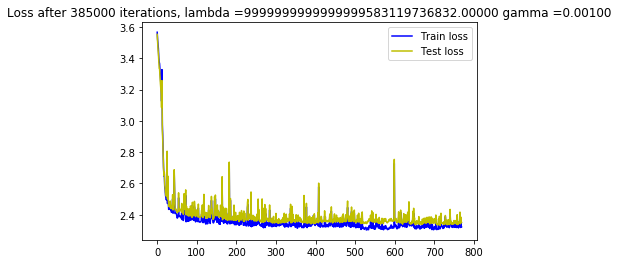

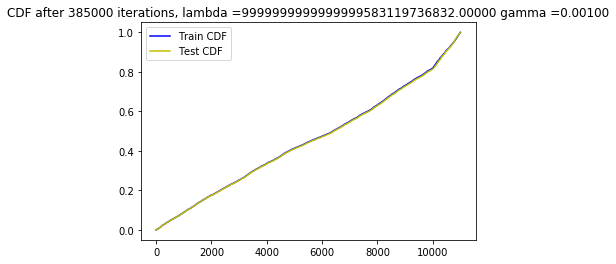

 81%|████████▏ | 385008/473047 [3:57:21<16:44:52,  1.46it/s]

New score:  0.1675162
Train score:  0.47140655
Test score:  0.45483646


 82%|████████▏ | 389997/473047 [4:00:17<18:55, 73.13it/s]   

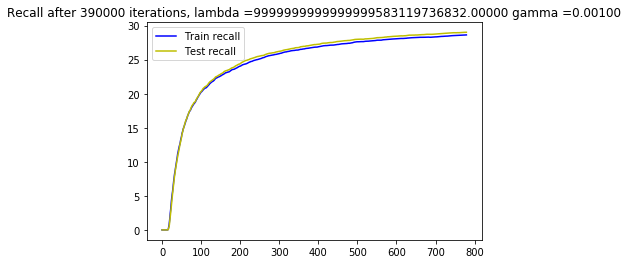

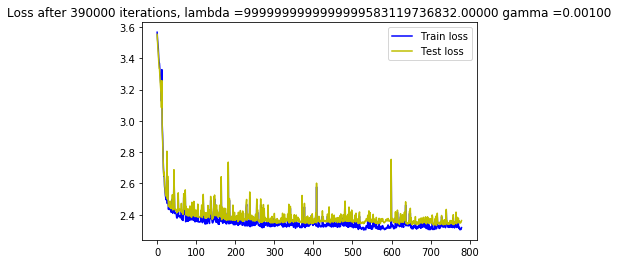

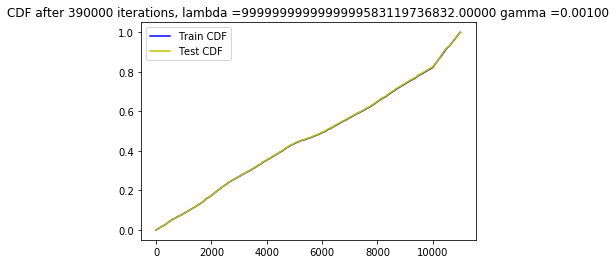

 82%|████████▏ | 390013/473047 [4:00:30<7:48:18,  2.96it/s] 

New score:  0.26401946
Train score:  0.2948412
Test score:  0.35009217


 84%|████████▎ | 394997/473047 [4:03:26<17:59, 72.33it/s]   

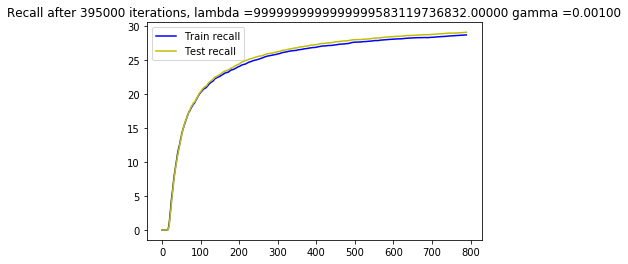

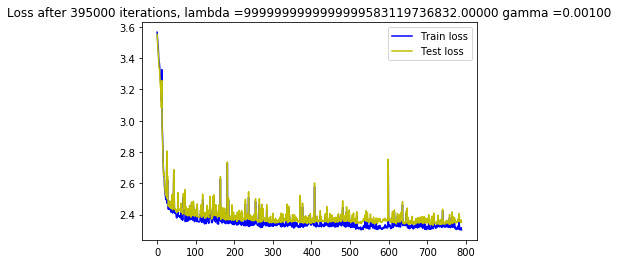

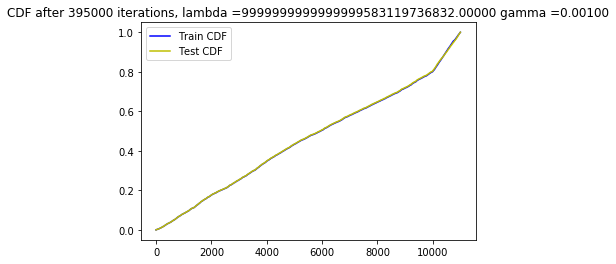

 84%|████████▎ | 395013/473047 [4:03:38<7:20:55,  2.95it/s] 

New score:  0.23947342
Train score:  0.44296917
Test score:  0.4454779


 85%|████████▍ | 399993/473047 [4:06:34<16:43, 72.81it/s]   

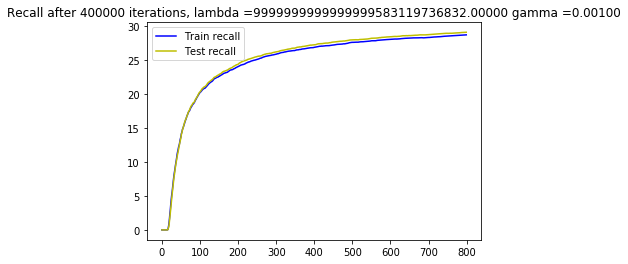

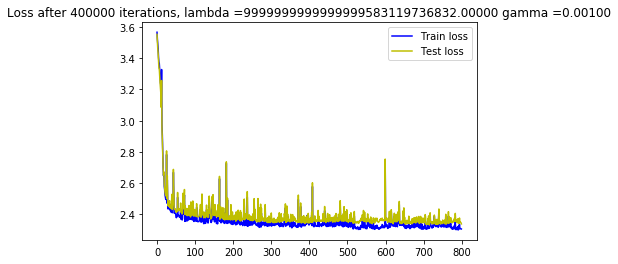

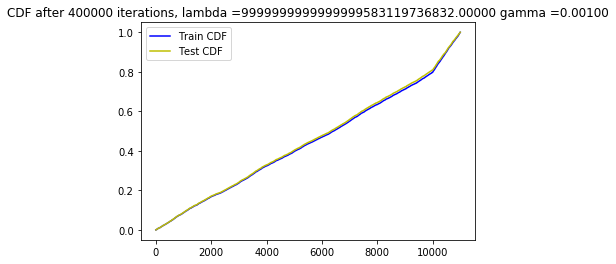

 85%|████████▍ | 400009/473047 [4:06:48<7:35:20,  2.67it/s] 

New score:  0.15069489
Train score:  0.4615671
Test score:  0.35859826


 86%|████████▌ | 404995/473047 [4:09:43<15:18, 74.07it/s]   

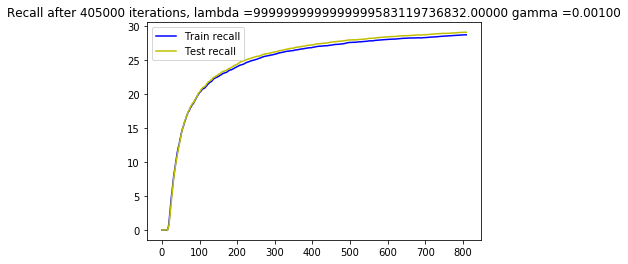

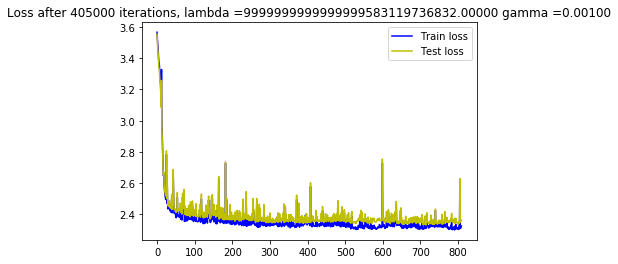

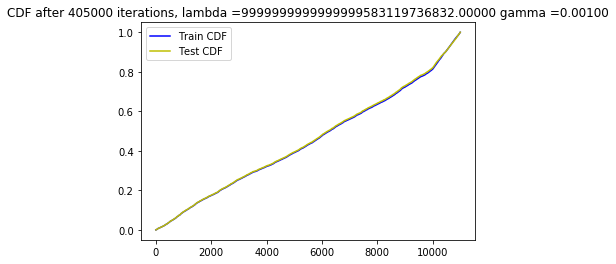

 86%|████████▌ | 405011/473047 [4:09:56<6:16:34,  3.01it/s]

New score:  0.19402564
Train score:  0.47520566
Test score:  0.4676966


 87%|████████▋ | 409997/473047 [4:13:00<14:11, 74.04it/s]   

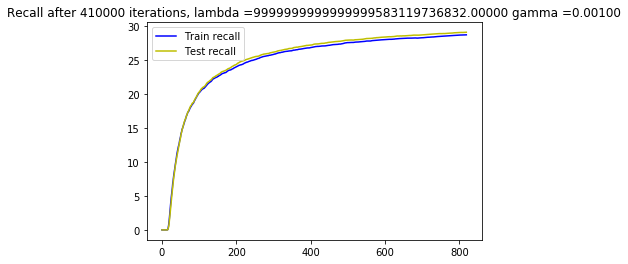

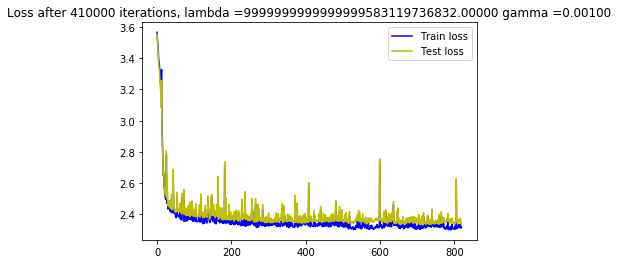

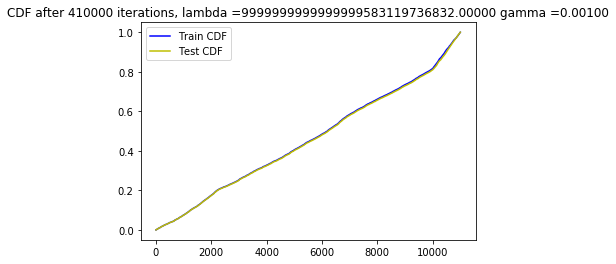

 87%|████████▋ | 410009/473047 [4:13:01<11:24:04,  1.54it/s]

New score:  0.1084767
Train score:  0.49401283
Test score:  0.41230035


 88%|████████▊ | 414997/473047 [4:15:55<13:04, 73.96it/s]   

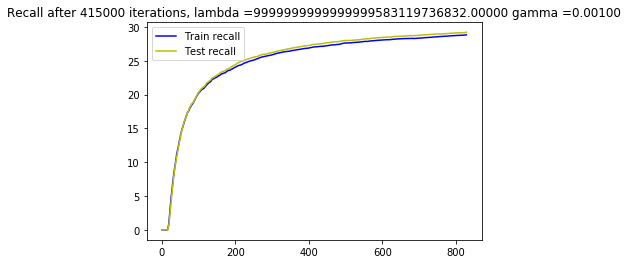

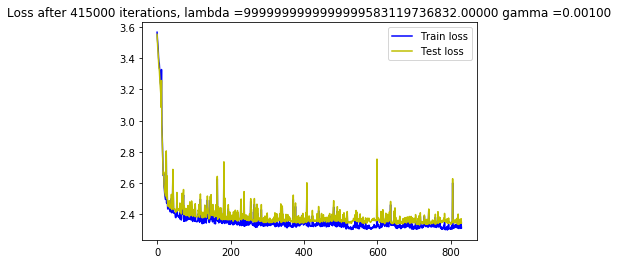

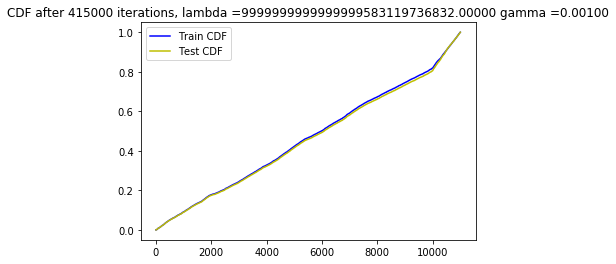

 88%|████████▊ | 415013/473047 [4:16:07<5:22:03,  3.00it/s]

New score:  0.20755497
Train score:  0.3454384
Test score:  0.48016053


 89%|████████▉ | 419995/473047 [4:19:02<12:07, 72.95it/s]   

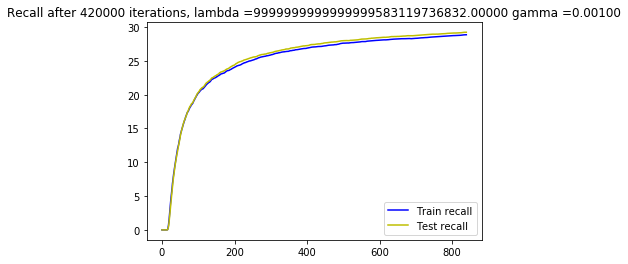

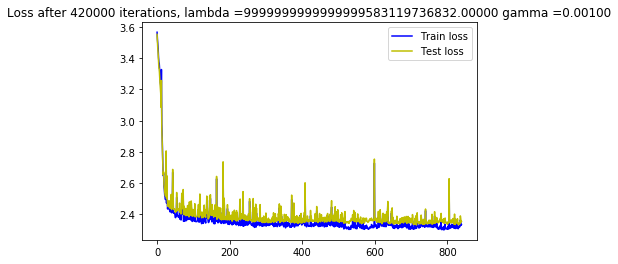

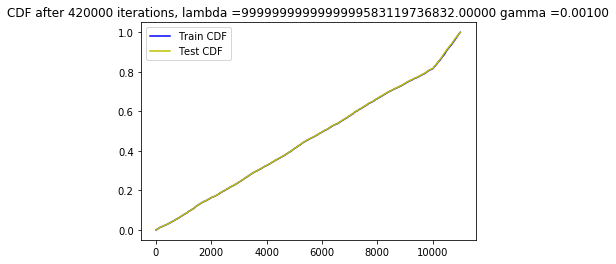

 89%|████████▉ | 420010/473047 [4:19:15<4:57:57,  2.97it/s]

New score:  0.08243402
Train score:  0.37334603
Test score:  0.36888486


 90%|████████▉ | 424997/473047 [4:22:20<10:46, 74.29it/s]   

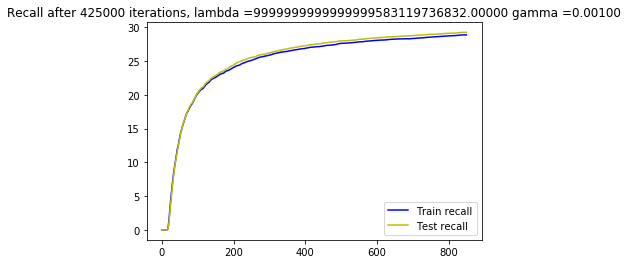

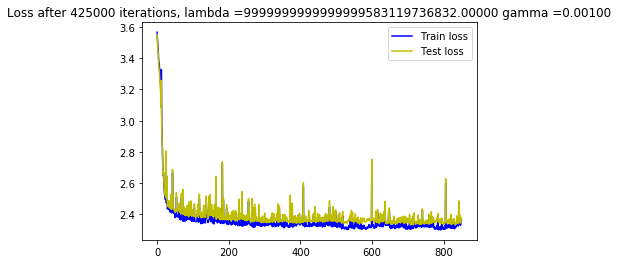

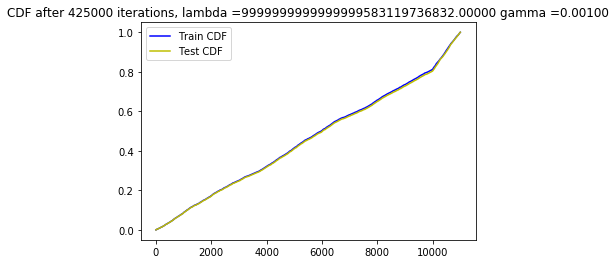

 90%|████████▉ | 425009/473047 [4:22:21<8:42:23,  1.53it/s] 

New score:  0.19272207
Train score:  0.2533124
Test score:  0.3861826


 91%|█████████ | 429997/473047 [4:25:14<09:42, 73.94it/s]   

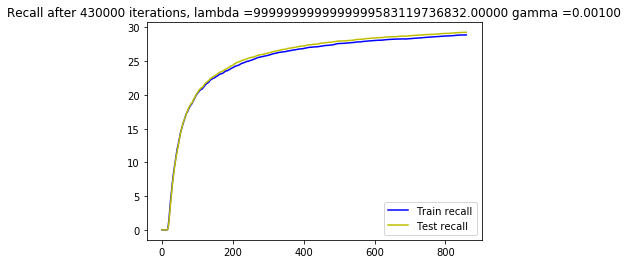

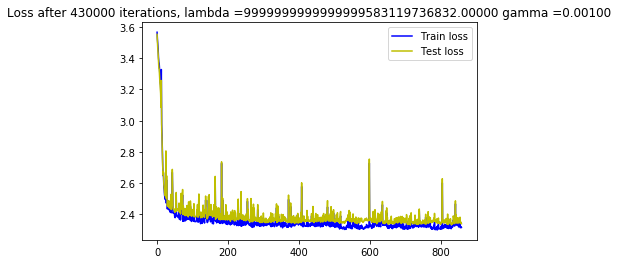

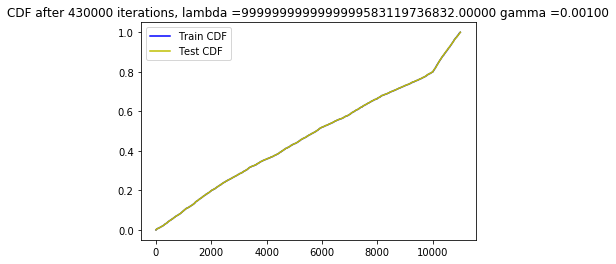

 91%|█████████ | 430013/473047 [4:25:27<3:59:31,  2.99it/s]

New score:  0.113265
Train score:  0.23123446
Test score:  0.3891595


 92%|█████████▏| 434993/473047 [4:28:30<08:39, 73.28it/s]   

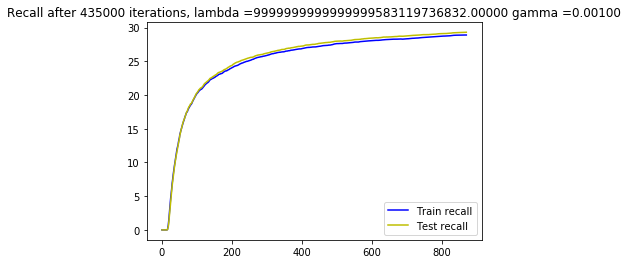

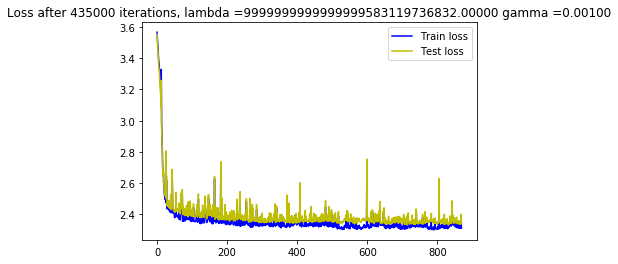

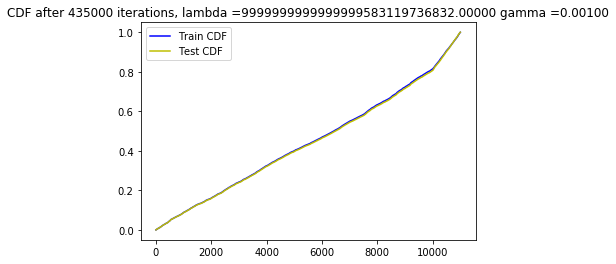

 92%|█████████▏| 435009/473047 [4:28:32<3:31:40,  3.00it/s]

New score:  0.19969672
Train score:  0.48725885
Test score:  0.35524508


 93%|█████████▎| 439997/473047 [4:31:28<07:30, 73.36it/s]  

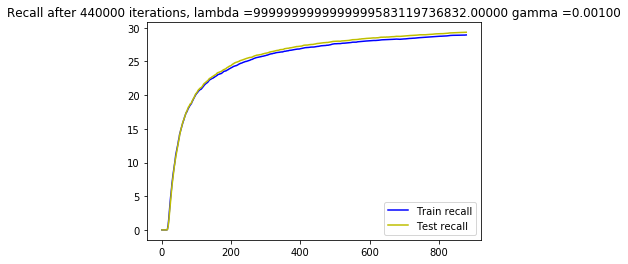

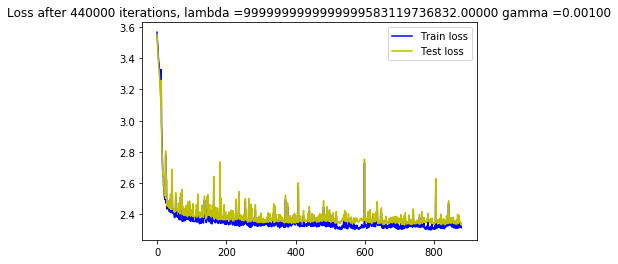

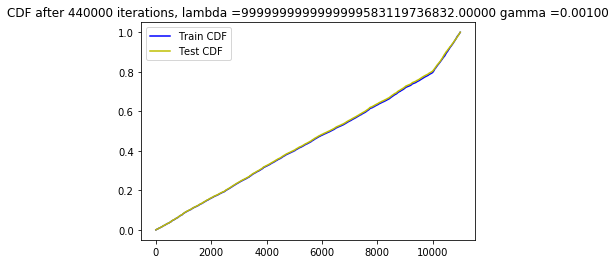

 93%|█████████▎| 440011/473047 [4:31:40<4:04:27,  2.25it/s]

New score:  0.12846705
Train score:  0.43444914
Test score:  0.43670312


 94%|█████████▍| 444997/473047 [4:34:36<06:24, 73.03it/s]   

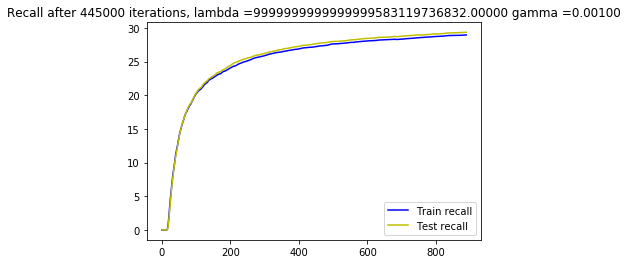

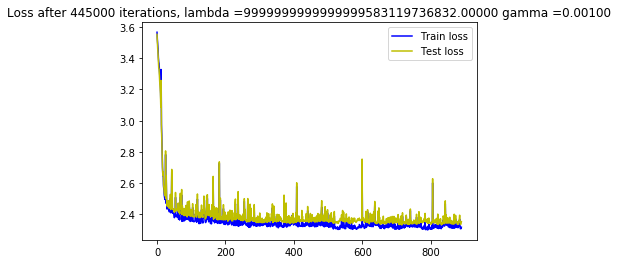

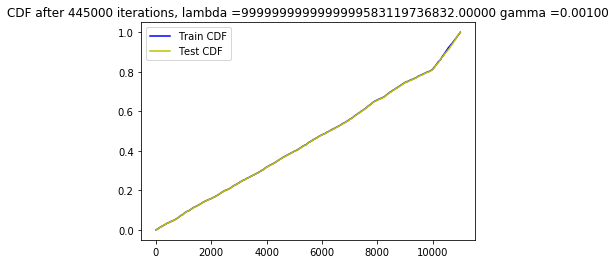

 94%|█████████▍| 445013/473047 [4:34:48<2:38:49,  2.94it/s]

New score:  0.18012969
Train score:  0.5453318
Test score:  0.38047224


 95%|█████████▌| 449993/473047 [4:37:43<05:15, 73.15it/s]   

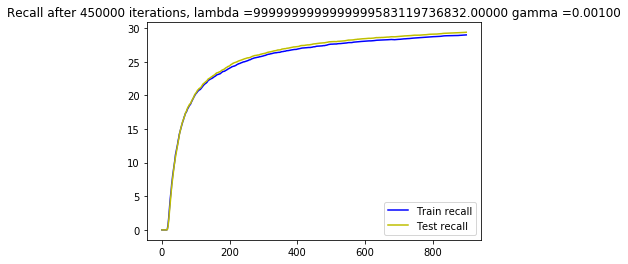

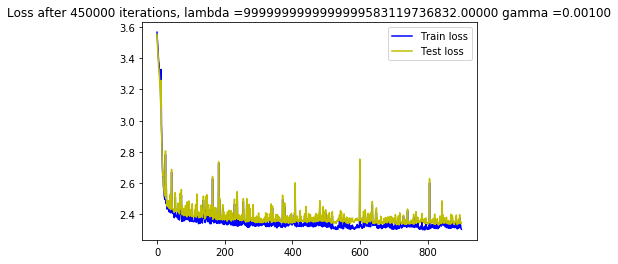

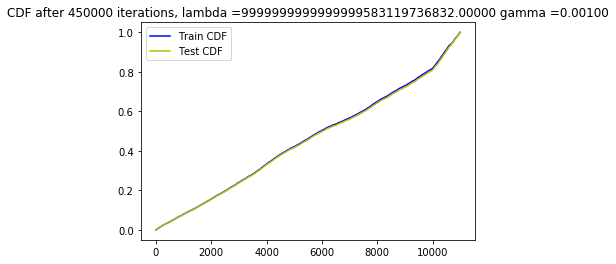

 95%|█████████▌| 450009/473047 [4:37:56<2:09:28,  2.97it/s]

New score:  0.17933147
Train score:  0.37630823
Test score:  0.42833892


 96%|█████████▌| 454997/473047 [4:40:52<04:20, 69.29it/s]  

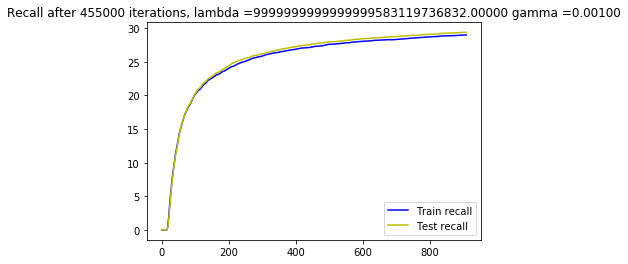

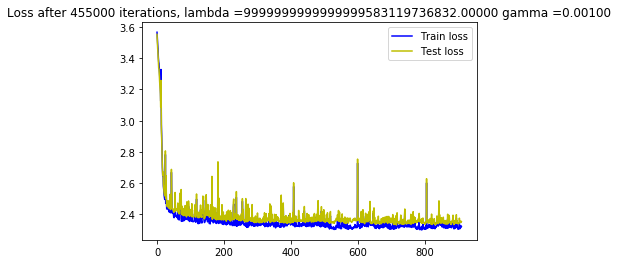

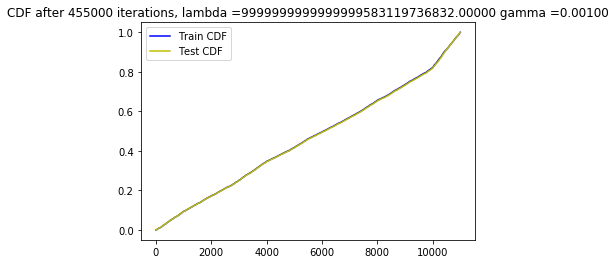

 96%|█████████▌| 455011/473047 [4:41:06<2:03:16,  2.44it/s]

New score:  0.17643836
Train score:  0.65702325
Test score:  0.38464862


 97%|█████████▋| 459997/473047 [4:44:05<03:03, 71.27it/s]  

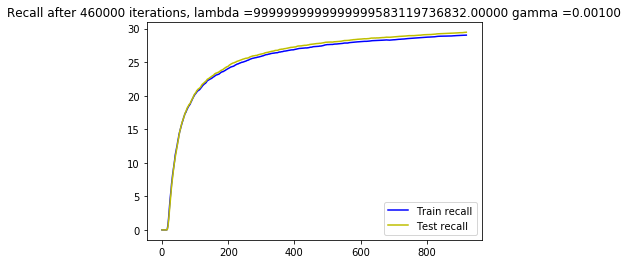

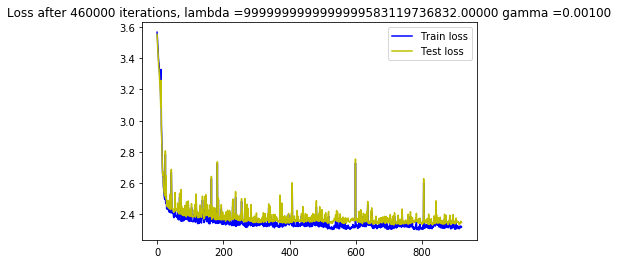

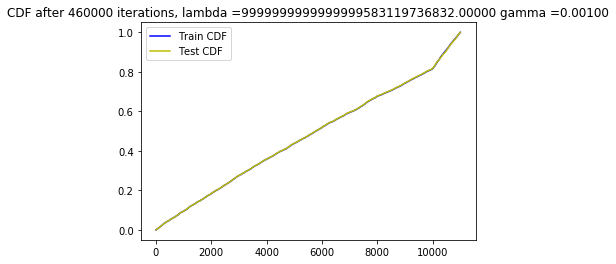

 97%|█████████▋| 460013/473047 [4:44:17<1:13:23,  2.96it/s]

New score:  0.13417011
Train score:  0.4388085
Test score:  0.52805233


 98%|█████████▊| 464997/473047 [4:47:12<01:46, 75.73it/s]  

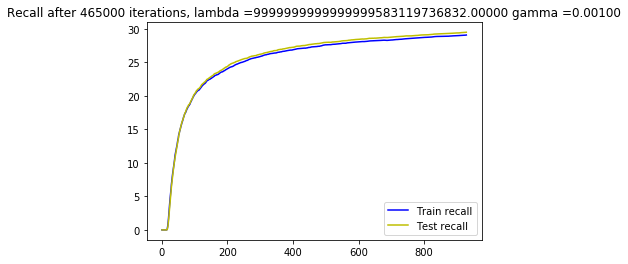

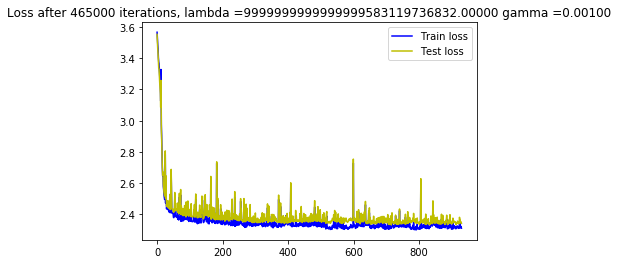

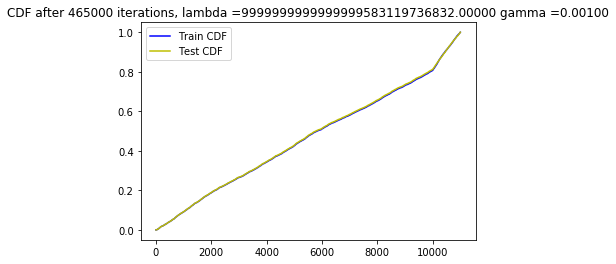

 98%|█████████▊| 465013/473047 [4:47:24<44:58,  2.98it/s]  

New score:  0.14074162
Train score:  0.33959776
Test score:  0.4298953


 99%|█████████▉| 469997/473047 [4:50:30<00:41, 73.39it/s]  

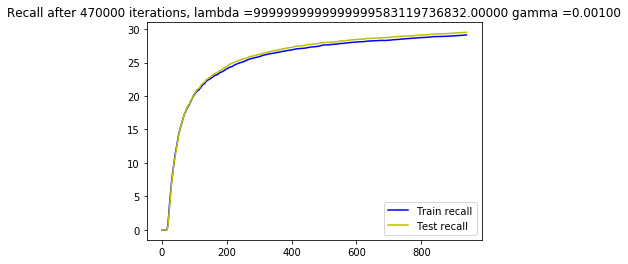

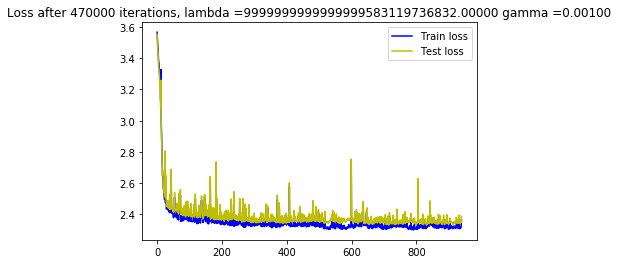

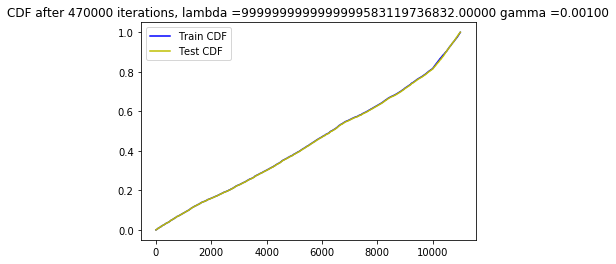

 99%|█████████▉| 470009/473047 [4:50:31<33:25,  1.51it/s]

New score:  0.1748643
Train score:  0.5580436
Test score:  0.38948113


100%|██████████| 473047/473047 [4:52:24<00:00, 26.96it/s]


In [11]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])